In [18]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. CHARGEMENT DES DONNÉES
# =========================
print("="*60)
print("CHARGEMENT DES DONNÉES")
print("="*60)

# Charger les données de fréquence
print("Chargement de freMTPL2freq.csv...")
df_freq = pd.read_csv('freMTPL2freq.csv')

# Charger les données de sévérité
print("Chargement de freMTPL2sev.csv...")
df_sev = pd.read_csv('freMTPL2sev.csv')

print(f"\nDimensions des datasets:")
print(f"- Fréquence (freMTPL2freq): {df_freq.shape}")
print(f"- Sévérité (freMTPL2sev): {df_sev.shape}")


CHARGEMENT DES DONNÉES
Chargement de freMTPL2freq.csv...
Chargement de freMTPL2sev.csv...

Dimensions des datasets:
- Fréquence (freMTPL2freq): (678013, 12)
- Sévérité (freMTPL2sev): (26639, 2)



NETTOYAGE ET FUSION DES DONNÉES

Premières lignes de fréquence:
   IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0    1.0        1      0.10         5       0       55          50      B12   
1    3.0        1      0.77         5       0       55          50      B12   
2    5.0        1      0.75         6       2       52          50      B12   
3   10.0        1      0.09         7       0       46          50      B12   
4   11.0        1      0.84         7       0       46          50      B12   

    VehGas Area  Density       Region  
0  Regular    D     1217  Rhone-Alpes  
1  Regular    D     1217  Rhone-Alpes  
2   Diesel    B       54     Picardie  
3   Diesel    B       76    Aquitaine  
4   Diesel    B       76    Aquitaine  

Colonnes fréquence: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Area', 'Density', 'Region']

Premières lignes de sévérité:
     IDpol  ClaimAmount
0     1552   

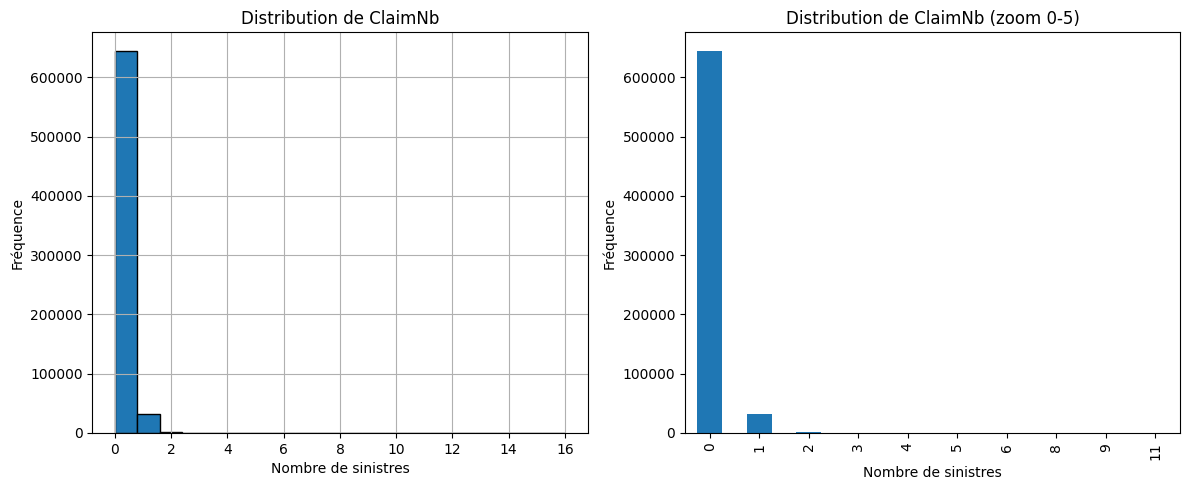


Statistiques de Exposure:
count    678013.000000
mean          0.528750
std           0.364442
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: Exposure, dtype: float64


In [2]:
# 2. NETTOYAGE ET FUSION DES DONNÉES
# ===================================
print("\n" + "="*60)
print("NETTOYAGE ET FUSION DES DONNÉES")
print("="*60)

# Afficher les premières lignes et informations
print("\nPremières lignes de fréquence:")
print(df_freq.head())
print("\nColonnes fréquence:", df_freq.columns.tolist())

print("\nPremières lignes de sévérité:")
print(df_sev.head())
print("\nColonnes sévérité:", df_sev.columns.tolist())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes dans fréquence:")
print(df_freq.isnull().sum())

print("\nValeurs manquantes dans sévérité:")
print(df_sev.isnull().sum())

# 3. PRÉPARATION DES DONNÉES DE FRÉQUENCE
# ========================================
print("\n" + "="*60)
print("PRÉPARATION DES DONNÉES DE FRÉQUENCE")
print("="*60)

# Vérifier les types de données
print("\nTypes de données dans fréquence:")
print(df_freq.dtypes)

# Statistiques descriptives
print("\nStatistiques descriptives fréquence:")
print(df_freq.describe())

# Distribution de la variable cible (ClaimNb)
print("\nDistribution de ClaimNb:")
print(df_freq['ClaimNb'].value_counts().sort_index())

# Visualisation de la distribution de ClaimNb
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_freq['ClaimNb'].hist(bins=20, edgecolor='black')
plt.title('Distribution de ClaimNb')
plt.xlabel('Nombre de sinistres')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
# Zoom sur 0-5 sinistres pour meilleure visualisation
df_freq['ClaimNb'].value_counts().sort_index().head(10).plot(kind='bar')
plt.title('Distribution de ClaimNb (zoom 0-5)')
plt.xlabel('Nombre de sinistres')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

# Vérifier l'exposition (Exposure)
print("\nStatistiques de Exposure:")
print(df_freq['Exposure'].describe())



PRÉPARATION DES DONNÉES DE SÉVÉRITÉ

Agrégation des sinistres par police...

Shape après agrégation: (24950, 4)
Nombre de polices avec sinistre: 24950

Statistiques descriptives des montants de sinistres:
       TotalClaimAmount  MeanClaimAmount
count      2.495000e+04     2.495000e+04
mean       2.432783e+03     2.221837e+03
std        3.036192e+04     2.898912e+04
min        1.000000e+00     1.000000e+00
25%        7.498400e+02     7.112150e+02
50%        1.172000e+03     1.172000e+03
75%        1.346400e+03     1.228080e+03
max        4.075401e+06     4.075401e+06


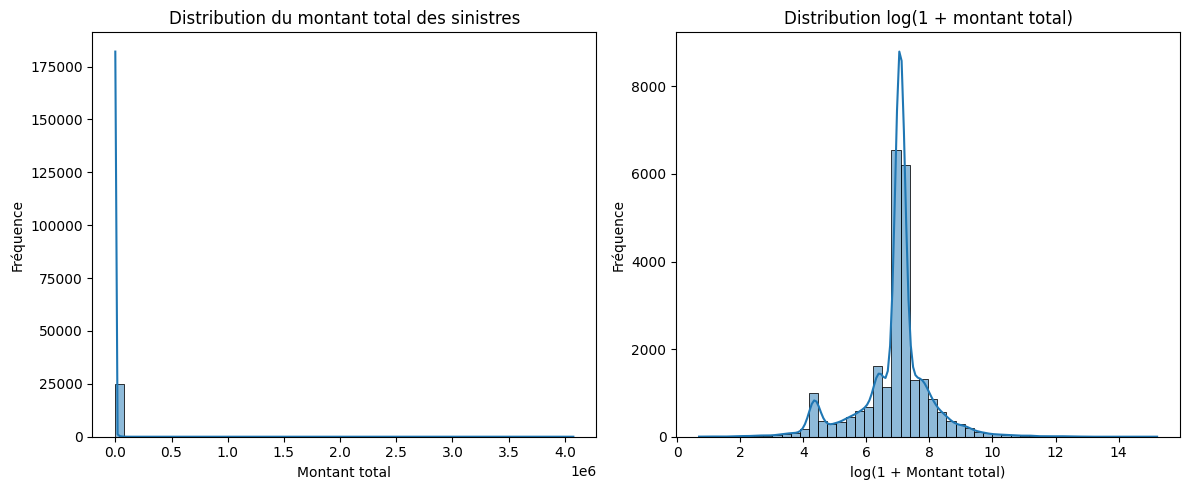

In [3]:
# 4. PRÉPARATION DES DONNÉES DE SÉVÉRITÉ
# ======================================
print("\n" + "="*60)
print("PRÉPARATION DES DONNÉES DE SÉVÉRITÉ")
print("="*60)

# Agréger les montants de sinistres par police
print("\nAgrégation des sinistres par police...")
df_sev_agg = df_sev.groupby('IDpol').agg({
    'ClaimAmount': ['sum', 'count', 'mean']
}).reset_index()

# Renommer les colonnes
df_sev_agg.columns = ['IDpol', 'TotalClaimAmount', 'ClaimCount', 'MeanClaimAmount']

print(f"\nShape après agrégation: {df_sev_agg.shape}")
print(f"Nombre de polices avec sinistre: {len(df_sev_agg)}")

# Statistiques descriptives des montants de sinistres
print("\nStatistiques descriptives des montants de sinistres:")
print(df_sev_agg[['TotalClaimAmount', 'MeanClaimAmount']].describe())

# Visualisation de la distribution des montants
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_sev_agg['TotalClaimAmount'], bins=50, kde=True)
plt.title('Distribution du montant total des sinistres')
plt.xlabel('Montant total')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
# Log-transform pour mieux voir la distribution
sns.histplot(np.log1p(df_sev_agg['TotalClaimAmount']), bins=50, kde=True)
plt.title('Distribution log(1 + montant total)')
plt.xlabel('log(1 + Montant total)')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()


In [4]:
# 5. FUSION DES DONNÉES DE FRÉQUENCE ET SÉVÉRITÉ
# ==============================================
print("\n" + "="*60)
print("FUSION DES DONNÉES")
print("="*60)

# Fusionner les données
df_merged = pd.merge(df_freq, df_sev_agg, on='IDpol', how='left')

# Remplir les valeurs manquantes pour les polices sans sinistre
df_merged['TotalClaimAmount'] = df_merged['TotalClaimAmount'].fillna(0)
df_merged['ClaimCount'] = df_merged['ClaimCount'].fillna(0)
df_merged['MeanClaimAmount'] = df_merged['MeanClaimAmount'].fillna(0)

print(f"\nShape après fusion: {df_merged.shape}")
print(f"Colonnes: {df_merged.columns.tolist()}")

# Vérifier la cohérence entre ClaimNb (de fréquence) et ClaimCount (de sévérité)
print("\nVérification cohérence ClaimNb vs ClaimCount:")
inconsistent = df_merged[df_merged['ClaimNb'] != df_merged['ClaimCount']].shape[0]
print(f"Nombre d'incohérences: {inconsistent}")

# Statistiques descriptives finales
print("\nStatistiques descriptives finales:")
print(f"Nombre total de polices: {len(df_merged)}")
print(f"Polices avec sinistre(s): {len(df_merged[df_merged['ClaimNb'] > 0])}")
print(f"Taux de sinistre: {len(df_merged[df_merged['ClaimNb'] > 0]) / len(df_merged):.2%}")
print(f"Nombre total de sinistres: {df_merged['ClaimNb'].sum()}")
print(f"Montant total des sinistres: {df_merged['TotalClaimAmount'].sum():.2f}")



FUSION DES DONNÉES

Shape après fusion: (678013, 15)
Colonnes: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Area', 'Density', 'Region', 'TotalClaimAmount', 'ClaimCount', 'MeanClaimAmount']

Vérification cohérence ClaimNb vs ClaimCount:
Nombre d'incohérences: 9117

Statistiques descriptives finales:
Nombre total de polices: 678013
Polices avec sinistre(s): 34060
Taux de sinistre: 5.02%
Nombre total de sinistres: 36102
Montant total des sinistres: 59909216.50


In [5]:
# 6. PRÉPARATION DES VARIABLES EXPLICATIVES
# =========================================
print("\n" + "="*60)
print("PRÉPARATION DES VARIABLES EXPLICATIVES")
print("="*60)

# Identifier les variables catégorielles et numériques
print("\nTypes de variables dans le dataset:")
print(df_merged.dtypes)

# Liste des variables explicatives (à adapter selon votre dataset)
# Variables catégorielles
categorical_cols = []
# Variables numériques
numeric_cols = []

# Vérifier chaque colonne
for col in df_merged.columns:
    if col not in ['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount', 'Exposure']:
        if df_merged[col].dtype == 'object':
            categorical_cols.append(col)
        elif df_merged[col].nunique() < 20:  # Si peu de valeurs uniques, traiter comme catégorielle
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)

print(f"\nVariables catégorielles ({len(categorical_cols)}): {categorical_cols}")
print(f"\nVariables numériques ({len(numeric_cols)}): {numeric_cols}")

# Afficher les valeurs uniques pour les variables catégorielles
print("\nValeurs uniques par variable catégorielle:")
for col in categorical_cols:
    unique_vals = df_merged[col].nunique()
    print(f"{col}: {unique_vals} valeurs uniques")



PRÉPARATION DES VARIABLES EXPLICATIVES

Types de variables dans le dataset:
IDpol               float64
ClaimNb               int64
Exposure            float64
VehPower              int64
VehAge                int64
DrivAge               int64
BonusMalus            int64
VehBrand             object
VehGas               object
Area                 object
Density               int64
Region               object
TotalClaimAmount    float64
ClaimCount          float64
MeanClaimAmount     float64
dtype: object

Variables catégorielles (5): ['VehPower', 'VehBrand', 'VehGas', 'Area', 'Region']

Variables numériques (4): ['VehAge', 'DrivAge', 'BonusMalus', 'Density']

Valeurs uniques par variable catégorielle:
VehPower: 12 valeurs uniques
VehBrand: 11 valeurs uniques
VehGas: 2 valeurs uniques
Area: 6 valeurs uniques
Region: 21 valeurs uniques


In [6]:
# 7. PRÉPARATION DES DONNÉES POUR LA MODÉLISATION
# ================================================
print("\n" + "="*60)
print("PRÉPARATION POUR LA MODÉLISATION")
print("="*60)

# Séparer les données pour la modélisation de fréquence
X_freq = df_merged.drop(['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount'], axis=1)
y_freq = df_merged['ClaimNb']
exposure = df_merged['Exposure']

print(f"\nDimensions pour la modélisation de fréquence:")
print(f"X_freq: {X_freq.shape}")
print(f"y_freq: {y_freq.shape}")

# Séparer les données pour la modélisation de sévérité
# Ne conserver que les polices avec sinistre
df_sev_only = df_merged[df_merged['ClaimNb'] > 0].copy()
X_sev = df_sev_only.drop(['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount'], axis=1)
y_sev = df_sev_only['MeanClaimAmount']  # Ou TotalClaimAmount selon le modèle
weights_sev = df_sev_only['ClaimNb']  # Poids = nombre de sinistres

print(f"\nDimensions pour la modélisation de sévérité:")
print(f"Polices avec sinistre: {len(df_sev_only)}")
print(f"X_sev: {X_sev.shape}")
print(f"y_sev: {y_sev.shape}")

# 8. CRÉATION DU PRÉPROCESSEUR
# ============================
print("\n" + "="*60)
print("CRÉATION DU PRÉPROCESSEUR")
print("="*60)

# Créer le préprocesseur avec OneHotEncoding pour les variables catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

print("Préprocesseur créé avec succès!")


PRÉPARATION POUR LA MODÉLISATION

Dimensions pour la modélisation de fréquence:
X_freq: (678013, 10)
y_freq: (678013,)

Dimensions pour la modélisation de sévérité:
Polices avec sinistre: 34060
X_sev: (34060, 10)
y_sev: (34060,)

CRÉATION DU PRÉPROCESSEUR
Préprocesseur créé avec succès!


In [7]:
# 9. MODÉLISATION DE FRÉQUENCE (CLAIMNB)
# =======================================
print("\n" + "="*60)
print("MODÉLISATION DE FRÉQUENCE")
print("="*60)

# Séparation train/test pour fréquence
X_freq_train, X_freq_test, y_freq_train, y_freq_test, exposure_train, exposure_test = train_test_split(
    X_freq, y_freq, exposure, test_size=0.2, random_state=42, stratify=(y_freq > 0)
)

print(f"Train size: {X_freq_train.shape[0]}")
print(f"Test size: {X_freq_test.shape[0]}")
print(f"Taux de sinistre train: {(y_freq_train > 0).mean():.2%}")
print(f"Taux de sinistre test: {(y_freq_test > 0).mean():.2%}")



MODÉLISATION DE FRÉQUENCE
Train size: 542410
Test size: 135603
Taux de sinistre train: 5.02%
Taux de sinistre test: 5.02%


In [8]:
# 9.1 GLM POISSON POUR LA FRÉQUENCE - Version simplifiée
print("\n--- 9.1 GLM POISSON (version simplifiée) ---")

# Méthode alternative: utiliser statsmodels formula API qui gère automatiquement les variables
print("Préparation des données avec formule...")

# Créer une copie des données pour éviter les modifications
X_freq_train_formula = X_freq_train.copy()
X_freq_test_formula = X_freq_test.copy()

# Ajouter les variables cibles et l'exposition
X_freq_train_formula['ClaimNb'] = y_freq_train.values
X_freq_train_formula['log_exposure'] = np.log(exposure_train.values)

X_freq_test_formula['ClaimNb'] = y_freq_test.values
X_freq_test_formula['log_exposure'] = np.log(exposure_test.values)

# Créer la formule pour le modèle
# Note: Vous devez ajuster les noms de variables selon votre dataset
formula = "ClaimNb ~ "

# Ajouter les variables numériques
for num_var in numeric_cols:
    formula += f" + {num_var}"

# Ajouter les variables catégorielles avec C() pour indiquer qu'elles sont catégorielles
for cat_var in categorical_cols:
    formula += f" + C({cat_var})"

print(f"Formule du modèle: {formula}")

# Ajuster le modèle avec la formule
try:
    poisson_model = smf.glm(
        formula=formula,
        data=X_freq_train_formula,
        family=sm.families.Poisson(),
        offset=X_freq_train_formula['log_exposure']
    ).fit()

    print("\nRésumé du modèle GLM Poisson (formula API):")
    print(poisson_model.summary())

    # Prédictions
    y_freq_pred_glm_train = poisson_model.predict(X_freq_train_formula)
    y_freq_pred_glm_test = poisson_model.predict(X_freq_test_formula)

except Exception as e:
    print(f"Erreur avec l'API formule: {e}")

    # Dernière solution: utiliser sklearn avec un modèle plus simple
    print("\nUtilisation de PoissonRegressor de sklearn...")
    from sklearn.linear_model import PoissonRegressor

    # Créer un pipeline avec le préprocesseur
    poisson_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', PoissonRegressor(alpha=1e-6, max_iter=1000))
    ])

    # Ajuster le modèle (sans offset pour simplifier)
    poisson_pipeline.fit(X_freq_train, y_freq_train)

    # Prédictions
    y_freq_pred_glm_train = poisson_pipeline.predict(X_freq_train)
    y_freq_pred_glm_test = poisson_pipeline.predict(X_freq_test)

    print("Modèle Poisson de sklearn ajusté avec succès!")



--- 9.1 GLM POISSON (version simplifiée) ---
Préparation des données avec formule...
Formule du modèle: ClaimNb ~  + VehAge + DrivAge + BonusMalus + Density + C(VehPower) + C(VehBrand) + C(VehGas) + C(Area) + C(Region)

Résumé du modèle GLM Poisson (formula API):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542410
Model:                            GLM   Df Residuals:                   542358
Model Family:                 Poisson   Df Model:                           51
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1459e+05
Date:                Sun, 18 Jan 2026   Deviance:                   1.7372e+05
Time:                        14:01:53   Pearson chi2:                 1.45e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01093
Covariance Type:        

In [9]:
# 9.2 GRADIENT BOOSTING POUR LA FRÉQUENCE
# =======================================
print("\n--- 9.2 Gradient Boosting pour la fréquence ---")

# Créer un pipeline avec préprocessing et XGBoost
xgb_poisson_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='count:poisson',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

print("Entraînement de XGBoost Poisson...")
xgb_poisson_pipeline.fit(X_freq_train, y_freq_train)

# Prédictions
y_freq_pred_xgb_train = xgb_poisson_pipeline.predict(X_freq_train)
y_freq_pred_xgb_test = xgb_poisson_pipeline.predict(X_freq_test)


--- 9.2 Gradient Boosting pour la fréquence ---
Entraînement de XGBoost Poisson...


In [20]:
# 9.3 ÉVALUATION DES MODÈLES DE FRÉQUENCE
# ========================================
print("\n--- 9.3 Évaluation des modèles de fréquence ---")

# Fonction pour calculer la déviance de Poisson
def poisson_deviance(y_true, y_pred):
    mask = y_true > 0
    dev = 2 * np.sum(y_true[mask] * np.log(y_true[mask]/y_pred[mask]) - (y_true[mask] - y_pred[mask]))
    dev += 2 * np.sum(y_pred[~mask])  # Pour y_true = 0
    return dev

# Calcul des métriques pour GLM Poisson
poisson_dev_glm_train = poisson_deviance(y_freq_train.values, y_freq_pred_glm_train)
poisson_dev_glm_test = poisson_deviance(y_freq_test.values, y_freq_pred_glm_test)
mae_glm = mean_absolute_error(y_freq_test, y_freq_pred_glm_test)
rmse_glm = np.sqrt(mean_squared_error(y_freq_test, y_freq_pred_glm_test))
pseudo_r2_glm = 1 - poisson_dev_glm_test/poisson_dev_glm_train

print("\nGLM Poisson:")
print(f"Déviance Poisson (train): {poisson_dev_glm_train:.4f}")
print(f"Déviance Poisson (test): {poisson_dev_glm_test:.4f}")
print(f"MAE (test): {mae_glm:.4f}")
print(f"RMSE (test): {rmse_glm:.4f}")
print(f"Pseudo-R² (déviance): {pseudo_r2_glm:.4f}")

# Calcul des métriques pour XGBoost Poisson
poisson_dev_xgb_train = poisson_deviance(y_freq_train.values, y_freq_pred_xgb_train)
poisson_dev_xgb_test = poisson_deviance(y_freq_test.values, y_freq_pred_xgb_test)
mae_xgb = mean_absolute_error(y_freq_test, y_freq_pred_xgb_test)
rmse_xgb = np.sqrt(mean_squared_error(y_freq_test, y_freq_pred_xgb_test))
pseudo_r2_xgb = 1 - poisson_dev_xgb_test/poisson_dev_xgb_train

print("\nXGBoost Poisson:")
print(f"Déviance Poisson (train): {poisson_dev_xgb_train:.4f}")
print(f"Déviance Poisson (test): {poisson_dev_xgb_test:.4f}")
print(f"MAE (test): {mae_xgb:.4f}")
print(f"RMSE (test): {rmse_xgb:.4f}")
print(f"Pseudo-R² (déviance): {pseudo_r2_xgb:.4f}")

# Comparaison GLM vs Gradient Boosting pour la fréquence
print("\n" + "="*60)
print("COMPARAISON GLM vs GRADIENT BOOSTING - FRÉQUENCE")
print("="*60)

comparison_freq = pd.DataFrame({
    'Modèle': ['GLM Poisson', 'XGBoost Poisson'],
    'Déviance (test)': [poisson_dev_glm_test, poisson_dev_xgb_test],
    'MAE': [mae_glm, mae_xgb],
    'RMSE': [rmse_glm, rmse_xgb],
    'Pseudo-R²': [pseudo_r2_glm, pseudo_r2_xgb]
})

print("\nComparaison des modèles de fréquence:")
print(comparison_freq.to_string(index=False))

# Trier par Déviance (meilleur en premier - plus petite déviance)
comparison_freq_sorted_dev = comparison_freq.sort_values('Déviance (test)')
print("\nComparaison triée par Déviance (meilleur en premier):")
print(comparison_freq_sorted_dev.to_string(index=False))

# Trier par Pseudo-R² (meilleur en premier - plus grand Pseudo-R²)
comparison_freq_sorted_r2 = comparison_freq.sort_values('Pseudo-R²', ascending=False)
print("\nComparaison triée par Pseudo-R² (meilleur en premier):")
print(comparison_freq_sorted_r2.to_string(index=False))

# Déterminer le meilleur modèle pour la fréquence
best_freq_model_dev = comparison_freq_sorted_dev.iloc[0]['Modèle']
best_freq_model_r2 = comparison_freq_sorted_r2.iloc[0]['Modèle']

print(f"\nMeilleur modèle de fréquence selon Déviance: {best_freq_model_dev}")
print(f"Meilleur modèle de fréquence selon Pseudo-R²: {best_freq_model_r2}")

# Note sur l'interprétation des métriques
print("\n" + "="*60)
print("INTERPRÉTATION DES MÉTRIQUES DE FRÉQUENCE")
print("="*60)
print("1. Déviance Poisson: Mesure d'erreur spécifique aux modèles Poisson.")
print("   - Plus la valeur est basse, meilleur est le modèle.")
print("   - Comparaison: réduction relative de déviance entre train et test.")
print("\n2. Pseudo-R² (basé sur déviance):")
print("   - Interprété comme proportion de déviance expliquée.")
print("   - Calcul: 1 - (déviance_test / déviance_train).")
print("   - Proche de 1: bon ajustement, proche de 0: faible ajustement.")
print("\n3. MAE (Mean Absolute Error):")
print("   - Erreur moyenne absolue entre prédictions et valeurs réelles.")
print("   - Plus facile à interpréter que la déviance (même unité que y).")
print("\n4. RMSE (Root Mean Square Error):")
print("   - Racine carrée de l'erreur quadratique moyenne.")
print("   - Donne plus de poids aux grandes erreurs que MAE.")


--- 9.3 Évaluation des modèles de fréquence ---

GLM Poisson:
Déviance Poisson (train): 190981.1287
Déviance Poisson (test): 47976.9597
MAE (test): 0.1493
RMSE (test): 0.2505
Pseudo-R² (déviance): 0.7488

XGBoost Poisson:
Déviance Poisson (train): 157251.8278
Déviance Poisson (test): 39755.5948
MAE (test): 0.0976
RMSE (test): 0.2362
Pseudo-R² (déviance): 0.7472

COMPARAISON GLM vs GRADIENT BOOSTING - FRÉQUENCE

Comparaison des modèles de fréquence:
         Modèle  Déviance (test)      MAE     RMSE  Pseudo-R²
    GLM Poisson     47976.959651 0.149326 0.250505   0.748787
XGBoost Poisson     39755.594832 0.097642 0.236177   0.747185

Comparaison triée par Déviance (meilleur en premier):
         Modèle  Déviance (test)      MAE     RMSE  Pseudo-R²
XGBoost Poisson     39755.594832 0.097642 0.236177   0.747185
    GLM Poisson     47976.959651 0.149326 0.250505   0.748787

Comparaison triée par Pseudo-R² (meilleur en premier):
         Modèle  Déviance (test)      MAE     RMSE  Pseudo-R²
 

In [11]:
# 10. MODÉLISATION DE SÉVÉRITÉ (MEANCLAIMAMOUNT)
# ===============================================
print("\n" + "="*60)
print("MODÉLISATION DE SÉVÉRITÉ")
print("="*60)

# Si df_merged n'est pas défini, nous devons recréer les données
# Charger les données et effectuer la fusion si nécessaire
try:
    # Vérifier si df_merged existe
    if 'df_merged' not in locals():
        print("df_merged n'est pas défini, chargement des données...")

        # Charger les données
        df_freq = pd.read_csv('freMTPL2freq.csv')
        df_sev = pd.read_csv('freMTPL2sev.csv')

        # Agréger les données de sévérité
        df_sev_agg = df_sev.groupby('IDpol').agg({
            'ClaimAmount': ['sum', 'count', 'mean']
        }).reset_index()

        df_sev_agg.columns = ['IDpol', 'TotalClaimAmount', 'ClaimCount', 'MeanClaimAmount']

        # Fusionner les données
        df_merged = pd.merge(df_freq, df_sev_agg, on='IDpol', how='left')

        # Remplir les valeurs manquantes
        df_merged['TotalClaimAmount'] = df_merged['TotalClaimAmount'].fillna(0)
        df_merged['ClaimCount'] = df_merged['ClaimCount'].fillna(0)
        df_merged['MeanClaimAmount'] = df_merged['MeanClaimAmount'].fillna(0)

        print(f"df_merged créé avec shape: {df_merged.shape}")

    # Maintenant définir les variables pour la modélisation de sévérité
    print("Préparation des données pour la modélisation de sévérité...")

    # Identifier les variables catégorielles et numériques si nécessaire
    if 'categorical_cols' not in locals() or 'numeric_cols' not in locals():
        categorical_cols = []
        numeric_cols = []

        for col in df_merged.columns:
            if col not in ['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount', 'Exposure']:
                if df_merged[col].dtype == 'object':
                    categorical_cols.append(col)
                elif df_merged[col].nunique() < 20:
                    categorical_cols.append(col)
                else:
                    numeric_cols.append(col)

        print(f"Variables catégorielles: {categorical_cols}")
        print(f"Variables numériques: {numeric_cols}")

    # Ne conserver que les polices avec sinistre
    df_sev_only = df_merged[df_merged['ClaimNb'] > 0].copy()

    # Définir les variables pour la modélisation de sévérité
    X_sev = df_sev_only.drop(['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount'], axis=1)
    y_sev = df_sev_only['MeanClaimAmount']  # Ou TotalClaimAmount selon le modèle
    weights_sev = df_sev_only['ClaimNb']  # Poids = nombre de sinistres

    print(f"Polices avec sinistre: {len(df_sev_only)}")
    print(f"X_sev shape: {X_sev.shape}")
    print(f"y_sev shape: {y_sev.shape}")

except Exception as e:
    print(f"Erreur lors de la préparation des données: {e}")
    # Si quelque chose ne va pas, nous devons peut-être charger les bibliothèques
    import pandas as pd
    import numpy as np
    print("Bibliothèques pandas et numpy importées.")

    # Réessayer avec une approche plus simple
    print("Tentative alternative de chargement des données...")

    # Charger les données
    df_freq = pd.read_csv('freMTPL2freq.csv')
    df_sev = pd.read_csv('freMTPL2sev.csv')

    # Agréger les données de sévérité
    df_sev_agg = df_sev.groupby('IDpol').agg({
        'ClaimAmount': ['sum', 'count', 'mean']
    }).reset_index()

    df_sev_agg.columns = ['IDpol', 'TotalClaimAmount', 'ClaimCount', 'MeanClaimAmount']

    # Fusionner les données
    df_merged = pd.merge(df_freq, df_sev_agg, on='IDpol', how='left')

    # Remplir les valeurs manquantes
    df_merged['TotalClaimAmount'] = df_merged['TotalClaimAmount'].fillna(0)
    df_merged['ClaimCount'] = df_merged['ClaimCount'].fillna(0)
    df_merged['MeanClaimAmount'] = df_merged['MeanClaimAmount'].fillna(0)

    # Identifier les variables
    categorical_cols = []
    numeric_cols = []

    for col in df_merged.columns:
        if col not in ['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount', 'Exposure']:
            if df_merged[col].dtype == 'object':
                categorical_cols.append(col)
            elif df_merged[col].nunique() < 20:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)

    # Préparer les données pour la modélisation de sévérité
    df_sev_only = df_merged[df_merged['ClaimNb'] > 0].copy()
    X_sev = df_sev_only.drop(['IDpol', 'ClaimNb', 'ClaimCount', 'TotalClaimAmount', 'MeanClaimAmount'], axis=1)
    y_sev = df_sev_only['MeanClaimAmount']
    weights_sev = df_sev_only['ClaimNb']

# Maintenant, séparation train/test pour sévérité (uniquement les polices avec sinistres)
X_sev_train, X_sev_test, y_sev_train, y_sev_test, weights_train, weights_test = train_test_split(
    X_sev, y_sev, weights_sev, test_size=0.2, random_state=42
)

print(f"\nTrain size (sévérité): {X_sev_train.shape[0]}")
print(f"Test size (sévérité): {X_sev_test.shape[0]}")
print(f"Moyenne des sinistres train: {y_sev_train.mean():.2f}")
print(f"Moyenne des sinistres test: {y_sev_test.mean():.2f}")
print(f"Distribution des poids (ClaimNb) - Train: {weights_train.describe()}")
print(f"Distribution des poids (ClaimNb) - Test: {weights_test.describe()}")



MODÉLISATION DE SÉVÉRITÉ
Préparation des données pour la modélisation de sévérité...
Polices avec sinistre: 34060
X_sev shape: (34060, 10)
y_sev shape: (34060,)

Train size (sévérité): 27248
Test size (sévérité): 6812
Moyenne des sinistres train: 1651.97
Moyenne des sinistres test: 1526.32
Distribution des poids (ClaimNb) - Train: count    27248.000000
mean         1.061142
std          0.294811
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: ClaimNb, dtype: float64
Distribution des poids (ClaimNb) - Test: count    6812.000000
mean        1.055197
std         0.235969
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: ClaimNb, dtype: float64


In [12]:
# 10.1 GLM GAMMA POUR LA SÉVÉRITÉ
print("\n--- 10.1 GLM Gamma pour la sévérité ---")

# Créer une formule pour le modèle Gamma
formula_sev = "MeanClaimAmount ~ "

# Ajouter les variables numériques
for num_var in numeric_cols:
    formula_sev += f" + {num_var}"

# Ajouter les variables catégorielles
for cat_var in categorical_cols:
    formula_sev += f" + C({cat_var})"

print(f"Formule du modèle Gamma: {formula_sev}")

# Préparer les données pour statsmodels
X_sev_train_formula = X_sev_train.copy()
X_sev_train_formula['MeanClaimAmount'] = y_sev_train.values
X_sev_test_formula = X_sev_test.copy()
X_sev_test_formula['MeanClaimAmount'] = y_sev_test.values

# Ajuster le modèle Gamma
try:
    gamma_model = smf.glm(
        formula=formula_sev,
        data=X_sev_train_formula,
        family=sm.families.Gamma(link=sm.families.links.log()),
        freq_weights=weights_train
    ).fit()

    print("\nRésumé du modèle GLM Gamma:")
    print(gamma_model.summary())

    # Prédictions
    y_sev_pred_glm_train = gamma_model.predict(X_sev_train_formula)
    y_sev_pred_glm_test = gamma_model.predict(X_sev_test_formula)

    # Calculer la log-vraisemblance pour le modèle Gamma GLM
    # Pour un modèle Gamma avec lien log, la log-vraisemblance est donnée par:
    # log L = (1/phi) * ( -y / (mu * phi) - log(mu) ) + c(y, phi)
    # où phi est le paramètre de dispersion
    phi_glm = gamma_model.scale  # paramètre de dispersion

    # Fonction pour calculer la log-vraisemblance Gamma
    def gamma_log_likelihood(y_true, y_pred, phi):
        # Éviter les divisions par zéro et les log(0)
        y_true = np.maximum(y_true, 1e-8)
        y_pred = np.maximum(y_pred, 1e-8)

        # Calcul de la log-vraisemblance pour une distribution Gamma avec lien log
        # Formule simplifiée: log L = (1/phi) * (-y_true/(y_pred*phi) - np.log(y_pred)) + c(y_true, phi)
        # Le terme constant c(y_true, phi) est omis pour la comparaison car il est le même pour tous les modèles
        log_lik = (1/phi) * (-y_true/(y_pred*phi) - np.log(y_pred))
        return np.sum(log_lik)

    # Calcul de la log-vraisemblance pour GLM Gamma
    gamma_log_lik_glm_train = gamma_log_likelihood(y_sev_train.values, y_sev_pred_glm_train.values, phi_glm)
    gamma_log_lik_glm_test = gamma_log_likelihood(y_sev_test.values, y_sev_pred_glm_test.values, phi_glm)

except Exception as e:
    print(f"Erreur avec l'API formule: {e}")

    # Alternative avec sklearn
    print("\nUtilisation de GammaRegressor de sklearn...")

    # Créer un pipeline avec le préprocesseur
    gamma_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GammaRegressor(alpha=1e-6, max_iter=1000))
    ])

    # Ajuster le modèle
    gamma_pipeline.fit(X_sev_train, y_sev_train)

    # Prédictions
    y_sev_pred_glm_train = gamma_pipeline.predict(X_sev_train)
    y_sev_pred_glm_test = gamma_pipeline.predict(X_sev_test)

    print("Modèle Gamma de sklearn ajusté avec succès!")



--- 10.1 GLM Gamma pour la sévérité ---
Formule du modèle Gamma: MeanClaimAmount ~  + VehAge + DrivAge + BonusMalus + Density + C(VehPower) + C(VehBrand) + C(VehGas) + C(Area) + C(Region)

Résumé du modèle GLM Gamma:
                 Generalized Linear Model Regression Results                  
Dep. Variable:        MeanClaimAmount   No. Observations:                27248
Model:                            GLM   Df Residuals:                    28862
Model Family:                   Gamma   Df Model:                           51
Link Function:                    log   Scale:                          39.971
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Sun, 18 Jan 2026   Deviance:                   5.7918e+05
Time:                        14:05:29   Pearson chi2:                 1.15e+06
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                  

In [13]:
# 10.2 GRADIENT BOOSTING POUR LA SÉVÉRITÉ
print("\n--- 10.2 Gradient Boosting pour la sévérité ---")

# OPTION 1: Utiliser XGBoost avec un objectif de régression standard
# et transformer les données pour mieux correspondre à une distribution Gamma

# Transformons y pour mieux gérer la distribution (transformation log)
y_sev_train_log = np.log1p(y_sev_train)
y_sev_test_log = np.log1p(y_sev_test)

# Utiliser XGBoost avec objectif de régression standard
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',  # Objectif de régression standard
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

print("Entraînement de XGBoost avec transformation log...")
xgb_pipeline.fit(X_sev_train, y_sev_train_log)

# Prédictions sur l'échelle log
y_sev_pred_xgb_train_log = xgb_pipeline.predict(X_sev_train)
y_sev_pred_xgb_test_log = xgb_pipeline.predict(X_sev_test)

# Retourner à l'échelle originale
y_sev_pred_xgb_train = np.expm1(y_sev_pred_xgb_train_log)
y_sev_pred_xgb_test = np.expm1(y_sev_pred_xgb_test_log)

# OPTION 2: Utiliser LightGBM qui supporte la distribution Gamma
print("\n--- 10.2.2 LightGBM avec distribution Gamma ---")

try:
    # LightGBM supporte la distribution Gamma
    lgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lgb.LGBMRegressor(
            objective='gamma',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            verbose=-1  # Désactive les logs
        ))
    ])

    print("Entraînement de LightGBM Gamma...")
    lgb_pipeline.fit(X_sev_train, y_sev_train)

    # Prédictions
    y_sev_pred_lgb_train = lgb_pipeline.predict(X_sev_train)
    y_sev_pred_lgb_test = lgb_pipeline.predict(X_sev_test)

    lgb_success = True
    print("LightGBM Gamma entraîné avec succès!")

except Exception as e:
    print(f"Erreur avec LightGBM Gamma: {e}")
    print("Utilisation de XGBoost avec transformation log comme alternative.")
    lgb_success = False

# OPTION 3: Utiliser GradientBoostingRegressor de sklearn
print("\n--- 10.2.3 Gradient Boosting de sklearn ---")

sklearn_gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        loss='squared_error'
    ))
])

print("Entraînement de GradientBoostingRegressor...")
sklearn_gb_pipeline.fit(X_sev_train, y_sev_train)

# Prédictions
y_sev_pred_sklearn_train = sklearn_gb_pipeline.predict(X_sev_train)
y_sev_pred_sklearn_test = sklearn_gb_pipeline.predict(X_sev_test)


--- 10.2 Gradient Boosting pour la sévérité ---
Entraînement de XGBoost avec transformation log...

--- 10.2.2 LightGBM avec distribution Gamma ---
Entraînement de LightGBM Gamma...
Erreur avec LightGBM Gamma: Check failed: (label) > (0) at /__w/1/s/lightgbm-python/src/metric/regression_metric.hpp, line 274 .

Utilisation de XGBoost avec transformation log comme alternative.

--- 10.2.3 Gradient Boosting de sklearn ---
Entraînement de GradientBoostingRegressor...


In [14]:
# 10.3 ÉVALUATION DES MODÈLES DE SÉVÉRITÉ
print("\n--- 10.3 Évaluation des modèles de sévérité ---")

# Fonction pour calculer la déviance Gamma
def gamma_deviance(y_true, y_pred):
    epsilon = 1e-8  # Pour éviter les divisions par zéro
    y_pred = np.maximum(y_pred, epsilon)
    y_true = np.maximum(y_true, epsilon)  # Éviter les log(0)
    dev = 2 * np.sum(np.log(y_pred/y_true) + (y_true - y_pred)/y_pred)
    return dev

# Fonction d'évaluation complète (sans R²)
def evaluate_severity_model(y_true, y_pred, model_name, phi=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    deviance = gamma_deviance(y_true, y_pred)

    # Calcul de la log-vraisemblance si phi est fourni
    log_lik = None
    if phi is not None:
        log_lik = gamma_log_likelihood(y_true, y_pred, phi)

    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Déviance Gamma: {deviance:.4f}")
    if log_lik is not None:
        print(f"Log-vraisemblance: {log_lik:.4f}")

    return {
        'MAE': mae,
        'RMSE': rmse,
        'Deviance': deviance,
        'LogLikelihood': log_lik
    }

# Évaluation de tous les modèles
print("\n" + "="*60)
print("ÉVALUATION DES MODÈLES DE SÉVÉRITÉ")
print("="*60)

results = {}

# GLM Gamma
if 'phi_glm' in locals():
    results['GLM_Gamma'] = evaluate_severity_model(y_sev_test, y_sev_pred_glm_test, "GLM Gamma", phi_glm)
else:
    results['GLM_Gamma'] = evaluate_severity_model(y_sev_test, y_sev_pred_glm_test, "GLM Gamma")

# XGBoost avec transformation log
results['XGBoost_log'] = evaluate_severity_model(y_sev_test, y_sev_pred_xgb_test, "XGBoost (log transform)")

# LightGBM Gamma (si disponible)
if lgb_success:
    results['LightGBM_Gamma'] = evaluate_severity_model(y_sev_test, y_sev_pred_lgb_test, "LightGBM Gamma")

# GradientBoostingRegressor de sklearn
results['Sklearn_GB'] = evaluate_severity_model(y_sev_test, y_sev_pred_sklearn_test, "Sklearn Gradient Boosting")

# Comparaison synthétique
print("\n" + "="*60)
print("COMPARAISON SYNTHÉTIQUE DES MODÈLES DE SÉVÉRITÉ")
print("="*60)

# Créer un DataFrame pour comparer
comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'MAE': [r['MAE'] for r in results.values()],
    'RMSE': [r['RMSE'] for r in results.values()],
    'Déviance': [r['Deviance'] for r in results.values()]
})

# Ajouter Log-vraisemblance si disponible
if results['GLM_Gamma']['LogLikelihood'] is not None:
    comparison_df['LogLikelihood'] = [r['LogLikelihood'] for r in results.values()]

# Trier par Déviance (meilleur en premier)
comparison_df = comparison_df.sort_values('Déviance')
print("\nComparaison triée par Déviance (meilleur en premier):")
print(comparison_df.to_string(index=False))



--- 10.3 Évaluation des modèles de sévérité ---

ÉVALUATION DES MODÈLES DE SÉVÉRITÉ

GLM Gamma:
MAE: 1699.6742
RMSE: 11648.8407
Déviance Gamma: 98513.9798
Log-vraisemblance: -1245.0577

XGBoost (log transform):
MAE: 1284.4491
RMSE: 11669.4230
Déviance Gamma: 381998501054.1163

Sklearn Gradient Boosting:
MAE: 1580.0230
RMSE: 11867.6650
Déviance Gamma: 4198090087127.0889

COMPARAISON SYNTHÉTIQUE DES MODÈLES DE SÉVÉRITÉ

Comparaison triée par Déviance (meilleur en premier):
     Modèle         MAE         RMSE     Déviance  LogLikelihood
  GLM_Gamma 1699.674232 11648.840677 9.851398e+04   -1245.057749
XGBoost_log 1284.449149 11669.422989 3.819985e+11            NaN
 Sklearn_GB 1580.023005 11867.665008 4.198090e+12            NaN


In [23]:
# 11. CALCUL DE LA PRIME PURE
# ===========================
print("\n" + "="*60)
print("CALCUL DE LA PRIME PURE")
print("="*60)

# Utiliser les meilleurs modèles pour calculer la prime pure
print("\nUtilisation des meilleurs modèles pour le calcul de la prime pure...")

# Pour la fréquence, choisir le meilleur modèle basé sur la déviance
if poisson_dev_glm_test <= poisson_dev_xgb_test:
    best_freq_model = 'GLM_Poisson'
    print(f"Meilleur modèle fréquence: {best_freq_model}")
    # Prédictions de fréquence sur l'ensemble complet
    if 'poisson_model' in locals():
        X_freq_formula = X_freq.copy()
        X_freq_formula['ClaimNb'] = y_freq.values
        X_freq_formula['log_exposure'] = np.log(exposure.values)
        freq_predictions = poisson_model.predict(X_freq_formula)
    else:
        freq_predictions = poisson_pipeline.predict(X_freq)
else:
    best_freq_model = 'XGBoost_Poisson'
    print(f"Meilleur modèle fréquence: {best_freq_model}")
    freq_predictions = xgb_poisson_pipeline.predict(X_freq)

# Pour la sévérité, choisir le meilleur modèle basé sur la déviance
best_sev_model_name = comparison_df.iloc[0]['Modèle']
print(f"Meilleur modèle sévérité: {best_sev_model_name}")

# Créer X_sev_formula pour la prédiction avec le modèle Gamma GLM
X_sev_formula = X_sev.copy()
X_sev_formula['MeanClaimAmount'] = y_sev.values  # Valeur factice, nécessaire pour la formule

# Obtenir les prédictions de sévérité selon le meilleur modèle
if best_sev_model_name == 'GLM_Gamma':
    if 'gamma_model' in locals():
        sev_predictions = gamma_model.predict(X_sev_formula)
    else:
        sev_predictions = gamma_pipeline.predict(X_sev)
elif best_sev_model_name == 'XGBoost_log':
    # Prédire sur l'ensemble complet
    sev_predictions_log = xgb_pipeline.predict(X_sev)
    sev_predictions = np.expm1(sev_predictions_log)
elif best_sev_model_name == 'LightGBM_Gamma' and lgb_success:
    sev_predictions = lgb_pipeline.predict(X_sev)
else:  # Sklearn_GB
    sev_predictions = sklearn_gb_pipeline.predict(X_sev)

# Calcul de la prime pure: fréquence * sévérité
print("\nCalcul de la prime pure...")
# Pour les polices sans sinistre, utiliser la prédiction de sévérité moyenne
sev_predictions_all = np.zeros(len(df_merged))
sev_predictions_all[df_merged['ClaimNb'] > 0] = sev_predictions
# Pour les polices sans sinistre, utiliser la moyenne des prédictions
sev_mean = sev_predictions.mean()
sev_predictions_all[df_merged['ClaimNb'] == 0] = sev_mean

# Prime pure
pure_premium = freq_predictions * sev_predictions_all

# Ajouter au dataframe
df_merged['Predicted_Frequency'] = freq_predictions
df_merged['Predicted_Severity'] = sev_predictions_all
df_merged['Pure_Premium'] = pure_premium

# Statistiques des primes pures
print("\nStatistiques des primes pures calculées:")
print(df_merged['Pure_Premium'].describe())

# Comparaison avec le coût réel
df_merged['Actual_Cost'] = df_merged['TotalClaimAmount']
df_merged['Predicted_Cost'] = df_merged['Pure_Premium']

# Calculer l'erreur de prédiction
mae_total = mean_absolute_error(df_merged['Actual_Cost'], df_merged['Predicted_Cost'])
rmse_total = np.sqrt(mean_squared_error(df_merged['Actual_Cost'], df_merged['Predicted_Cost']))

print(f"\nPerformance globale du modèle de tarification:")
print(f"MAE (coût réel vs prédit): {mae_total:.4f}")
print(f"RMSE (coût réel vs prédit): {rmse_total:.4f}")

# Ratio de pertes (Loss Ratio) prédit vs réel
total_actual_cost = df_merged['Actual_Cost'].sum()
total_predicted_cost = df_merged['Predicted_Cost'].sum()
actual_premium = df_merged['Pure_Premium'].sum()  # Pour simuler la prime collectée

print(f"\nAnalyse actuarielle:")
print(f"Coût total réel: {total_actual_cost:.2f}")
print(f"Coût total prédit: {total_predicted_cost:.2f}")
print(f"Prime pure totale: {actual_premium:.2f}")
print(f"Loss ratio réel (coût/primes): {total_actual_cost/actual_premium:.2%}")
print(f"Loss ratio prédit (prédit/primes): {total_predicted_cost/actual_premium:.2%}")


CALCUL DE LA PRIME PURE

Utilisation des meilleurs modèles pour le calcul de la prime pure...
Meilleur modèle fréquence: XGBoost_Poisson
Meilleur modèle sévérité: GLM_Gamma

Calcul de la prime pure...

Statistiques des primes pures calculées:
count    678013.000000
mean         83.155025
std          70.797195
min           6.612104
25%          47.972750
50%          71.549844
75%         100.102720
max        5689.665463
Name: Pure_Premium, dtype: float64

Performance globale du modèle de tarification:
MAE (coût réel vs prédit): 161.4686
RMSE (coût réel vs prédit): 5821.6910

Analyse actuarielle:
Coût total réel: 59909216.50
Coût total prédit: 56380188.15
Prime pure totale: 56380188.15
Loss ratio réel (coût/primes): 106.26%
Loss ratio prédit (prédit/primes): 100.00%



VISUALISATION DES RÉSULTATS

--- 12.1 Distribution des primes pures ---


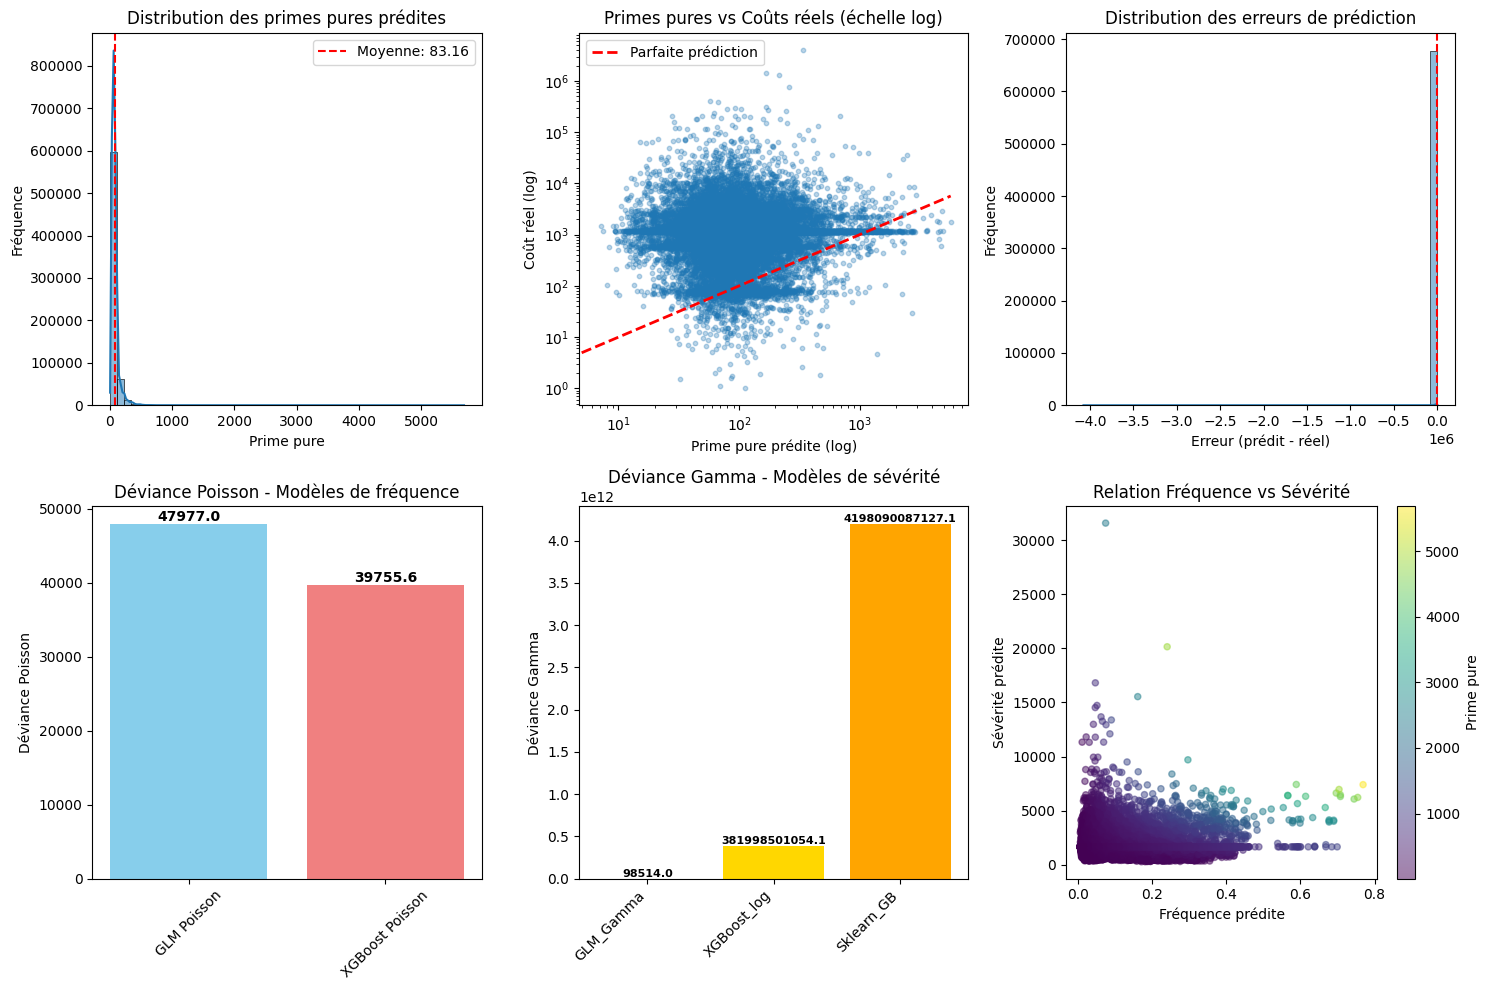


--- 12.3 Analyse par segment ---

Analyse par segment (VehPower):
          Pure_Premium  Actual_Cost  Nombre_Polices  Predicted_Frequency  \
VehPower                                                                   
9            87.990791   208.245061           30085             0.051713   
13           87.840430    96.160910            3229             0.051614   
5            87.018960    70.803368          124821             0.054171   
10           86.684489    91.003136           31354             0.052459   
6            86.076393    96.565533          148976             0.051696   
4            84.268938    81.579237          115349             0.051321   
15           82.826980    42.472126            2926             0.051208   
7            80.976494    85.462942          145401             0.049128   
14           76.373354   136.774464            2350             0.044121   
12           73.411007    86.155622            8214             0.043952   
11           71.46268

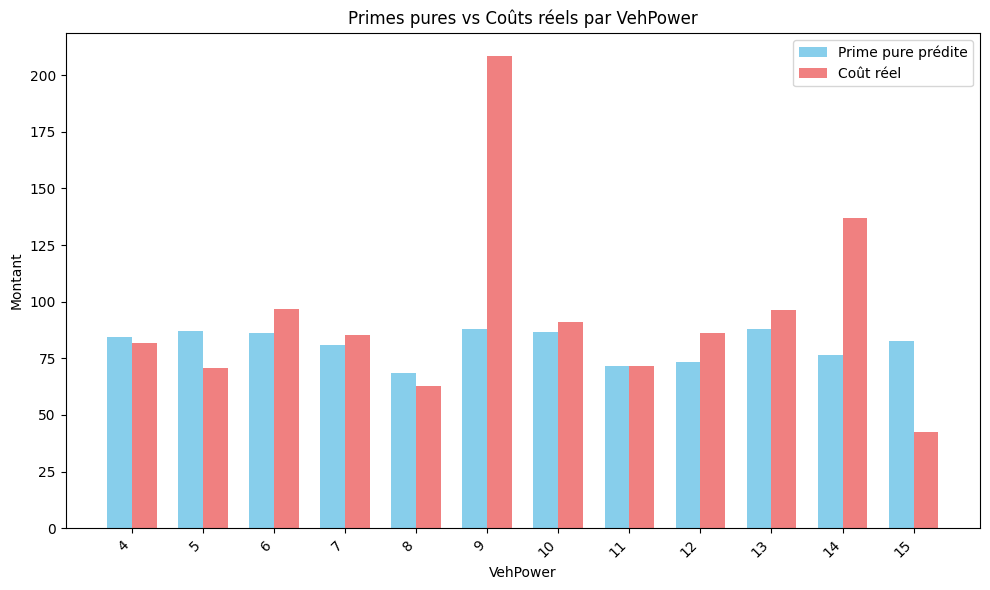

In [27]:
# 12. VISUALISATION DES RÉSULTATS
# ===============================
print("\n" + "="*60)
print("VISUALISATION DES RÉSULTATS")
print("="*60)

# 12.1 Distribution des primes pures
print("\n--- 12.1 Distribution des primes pures ---")

plt.figure(figsize=(15, 10))

# Graphique 1: Distribution des primes pures
plt.subplot(2, 3, 1)
sns.histplot(df_merged['Pure_Premium'], bins=50, kde=True)
plt.title('Distribution des primes pures prédites')
plt.xlabel('Prime pure')
plt.ylabel('Fréquence')
plt.axvline(x=df_merged['Pure_Premium'].mean(), color='r', linestyle='--', label=f"Moyenne: {df_merged['Pure_Premium'].mean():.2f}")
plt.legend()

# Graphique 2: Comparaison primes pures vs coûts réels (échelle log)
plt.subplot(2, 3, 2)
plt.scatter(df_merged['Pure_Premium'], df_merged['Actual_Cost'], alpha=0.3, s=10)
plt.plot([0, df_merged['Pure_Premium'].max()], [0, df_merged['Pure_Premium'].max()], 'r--', label='Parfaite prédiction', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.title('Primes pures vs Coûts réels (échelle log)')
plt.xlabel('Prime pure prédite (log)')
plt.ylabel('Coût réel (log)')
plt.legend()

# Graphique 3: Distribution des erreurs de prédiction
plt.subplot(2, 3, 3)
errors = df_merged['Predicted_Cost'] - df_merged['Actual_Cost']
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution des erreurs de prédiction')
plt.xlabel('Erreur (prédit - réel)')
plt.ylabel('Fréquence')
plt.axvline(x=0, color='r', linestyle='--')

# Graphique 4: Comparaison GLM vs Gradient Boosting pour la fréquence
plt.subplot(2, 3, 4)
freq_models = ['GLM Poisson', 'XGBoost Poisson']
freq_deviances = [poisson_dev_glm_test, poisson_dev_xgb_test]
bars = plt.bar(freq_models, freq_deviances, color=['skyblue', 'lightcoral'])
plt.title('Déviance Poisson - Modèles de fréquence')
plt.ylabel('Déviance Poisson')
plt.xticks(rotation=45)
# Ajouter les valeurs sur les barres
for bar, dev in zip(bars, freq_deviances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{dev:.1f}',
             ha='center', va='bottom', fontweight='bold')

# Graphique 5: Comparaison GLM vs Gradient Boosting pour la sévérité
plt.subplot(2, 3, 5)
sev_models = list(results.keys())
sev_deviances = [results[m]['Deviance'] for m in sev_models]
bars = plt.bar(sev_models, sev_deviances, color=['lightgreen', 'gold', 'orange', 'lightpink'][:len(sev_models)])
plt.title('Déviance Gamma - Modèles de sévérité')
plt.ylabel('Déviance Gamma')
plt.xticks(rotation=45, ha='right')
# Ajouter les valeurs sur les barres
for bar, dev in zip(bars, sev_deviances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{dev:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=8)

# Graphique 6: Relation fréquence-sévérité
plt.subplot(2, 3, 6)
scatter = plt.scatter(df_merged['Predicted_Frequency'], df_merged['Predicted_Severity'],
                     c=df_merged['Pure_Premium'], alpha=0.5, s=20, cmap='viridis')
plt.colorbar(scatter, label='Prime pure')
plt.title('Relation Fréquence vs Sévérité')
plt.xlabel('Fréquence prédite')
plt.ylabel('Sévérité prédite')
plt.tight_layout()

plt.tight_layout()
plt.show()



# 12.2 Analyse par segment
print("\n--- 12.3 Analyse par segment ---")

# Créer des segments basés sur les variables importantes
if len(categorical_cols) > 0:
    segment_var = categorical_cols[0]  # Prendre la première variable catégorielle
    segment_analysis = df_merged.groupby(segment_var).agg({
        'Pure_Premium': 'mean',
        'Actual_Cost': 'mean',
        'IDpol': 'count',
        'Predicted_Frequency': 'mean',
        'Predicted_Severity': 'mean'
    }).rename(columns={'IDpol': 'Nombre_Polices'})

    segment_analysis['Ratio_Obs_Pred'] = segment_analysis['Actual_Cost'] / segment_analysis['Pure_Premium']

    print(f"\nAnalyse par segment ({segment_var}):")
    print(segment_analysis.sort_values('Pure_Premium', ascending=False))

    # Visualisation
    plt.figure(figsize=(10, 6))
    x = range(len(segment_analysis))
    width = 0.35

    plt.bar(x, segment_analysis['Pure_Premium'], width, label='Prime pure prédite', color='skyblue')
    plt.bar([i + width for i in x], segment_analysis['Actual_Cost'], width, label='Coût réel', color='lightcoral')

    plt.xlabel(segment_var)
    plt.ylabel('Montant')
    plt.title(f'Primes pures vs Coûts réels par {segment_var}')
    plt.xticks([i + width/2 for i in x], segment_analysis.index, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:
# 14. VALIDATION DU MODÈLE ET ROBUSTESSE
# ======================================
print("\n" + "="*60)
print("VALIDATION DU MODÈLE ET ANALYSE DE ROBUSTESSE")
print("="*60)

# 14.1 Validation croisée pour la fréquence
print("\n--- 14.1 Validation croisée pour la modélisation de fréquence ---")

from sklearn.model_selection import cross_val_score, KFold

# Configuration de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Validation croisée pour GLM Poisson
print("\nValidation croisée pour GLM Poisson...")
if 'poisson_pipeline' in locals():
    glm_cv_scores = cross_val_score(
        poisson_pipeline, X_freq, y_freq,
        cv=cv, scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    print(f"MAE CV scores (GLM Poisson): {glm_cv_scores}")
    print(f"MAE CV mean: {-glm_cv_scores.mean():.4f}")
    print(f"MAE CV std: {glm_cv_scores.std():.4f}")

# Validation croisée pour XGBoost Poisson
print("\nValidation croisée pour XGBoost Poisson...")
xgb_cv_scores = cross_val_score(
    xgb_poisson_pipeline, X_freq, y_freq,
    cv=cv, scoring='neg_mean_absolute_error',
    n_jobs=-1
)
print(f"MAE CV scores (XGBoost): {xgb_cv_scores}")
print(f"MAE CV mean: {-xgb_cv_scores.mean():.4f}")
print(f"MAE CV std: {xgb_cv_scores.std():.4f}")



VALIDATION DU MODÈLE ET ANALYSE DE ROBUSTESSE

--- 14.1 Validation croisée pour la modélisation de fréquence ---

Validation croisée pour GLM Poisson...

Validation croisée pour XGBoost Poisson...
MAE CV scores (XGBoost): [-0.09753849 -0.09679062 -0.097358   -0.0982067  -0.09773112]
MAE CV mean: 0.0975
MAE CV std: 0.0005


In [29]:
# 14.2 Validation croisée pour la sévérité
print("\n--- 14.2 Validation croisée pour la modélisation de sévérité ---")

# Fonction de scoring personnalisée pour la déviance Gamma
def gamma_deviance_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -gamma_deviance(y, y_pred)  # Négatif car cross_val_score maximise

# Validation croisée pour le meilleur modèle de sévérité
print(f"\nValidation croisée pour {best_sev_model_name}...")

if best_sev_model_name == 'GLM_Gamma':
    if 'gamma_pipeline' in locals():
        sev_cv_scores = cross_val_score(
            gamma_pipeline, X_sev, y_sev,
            cv=cv, scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
elif best_sev_model_name == 'XGBoost_log':
    sev_cv_scores = cross_val_score(
        xgb_pipeline, X_sev, y_sev_log,  # Note: utiliser y_sev_log pour XGBoost_log
        cv=cv, scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
elif best_sev_model_name == 'Sklearn_GB':
    sev_cv_scores = cross_val_score(
        sklearn_gb_pipeline, X_sev, y_sev,
        cv=cv, scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

if 'sev_cv_scores' in locals():
    print(f"MAE CV scores ({best_sev_model_name}): {sev_cv_scores}")
    print(f"MAE CV mean: {-sev_cv_scores.mean():.4f}")
    print(f"MAE CV std: {sev_cv_scores.std():.4f}")



--- 14.2 Validation croisée pour la modélisation de sévérité ---

Validation croisée pour GLM_Gamma...



--- 14.3 Analyse de stabilité par décile de risque ---

Analyse par décile de risque:
             Pure_Premium  Actual_Cost  Nombre_Polices  Nombre_Sinistres  \
Risk_Decile                                                                
1               21.824573    54.280703           67802              2254   
2               36.115086    48.871100           67801              2245   
3               47.826348    65.520064           67844              3040   
4               57.874785    58.212918           67758              2543   
5               66.990641    66.939562           67802              2872   
6               76.468137    54.133169           67803              3053   
7               87.328643    71.158943           67799              3326   
8              100.207241    54.650304           67919              2780   
9              115.020233    67.434983           67794              3284   
10             222.101439   342.864174           67691             10705   



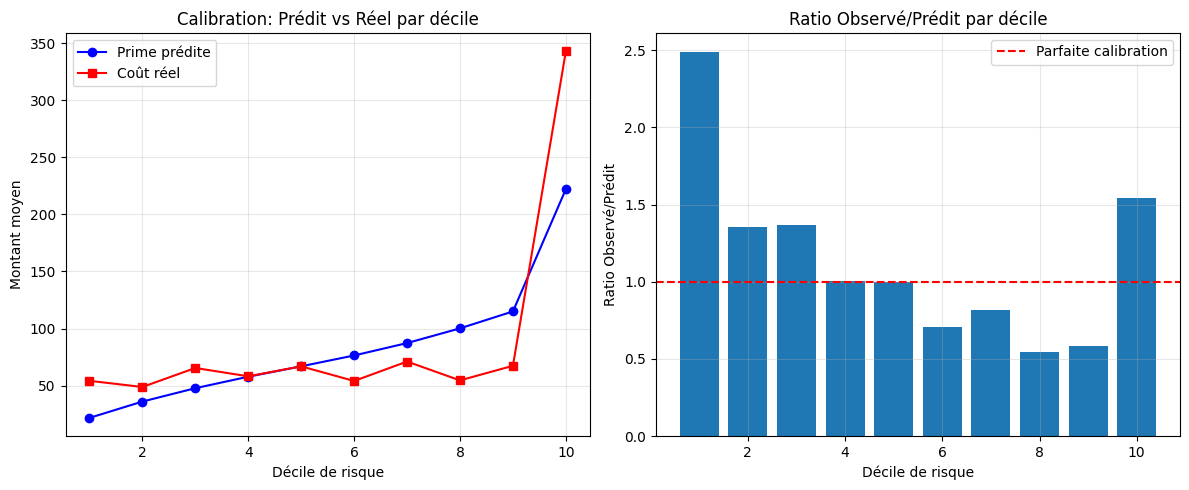

In [30]:
# 14.3 Analyse de stabilité par décile
print("\n--- 14.3 Analyse de stabilité par décile de risque ---")

# Calculer les déciles de risque prédit
df_merged['Risk_Decile'] = pd.qcut(df_merged['Pure_Premium'], q=10, labels=False) + 1

# Analyser la performance par décile
decile_analysis = df_merged.groupby('Risk_Decile').agg({
    'Pure_Premium': 'mean',
    'Actual_Cost': 'mean',
    'IDpol': 'count',
    'ClaimNb': 'sum'
}).rename(columns={'IDpol': 'Nombre_Polices', 'ClaimNb': 'Nombre_Sinistres'})

# Calculer le ratio observé/prédit
decile_analysis['Ratio_Obs_Pred'] = decile_analysis['Actual_Cost'] / decile_analysis['Pure_Premium']
decile_analysis['Freq_Obs'] = decile_analysis['Nombre_Sinistres'] / decile_analysis['Nombre_Polices']

print("\nAnalyse par décile de risque:")
print(decile_analysis)

# Visualisation de la calibration par décile
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(decile_analysis.index, decile_analysis['Pure_Premium'], 'b-', label='Prime prédite', marker='o')
plt.plot(decile_analysis.index, decile_analysis['Actual_Cost'], 'r-', label='Coût réel', marker='s')
plt.xlabel('Décile de risque')
plt.ylabel('Montant moyen')
plt.title('Calibration: Prédit vs Réel par décile')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(decile_analysis.index, decile_analysis['Ratio_Obs_Pred'])
plt.axhline(y=1, color='r', linestyle='--', label='Parfaite calibration')
plt.xlabel('Décile de risque')
plt.ylabel('Ratio Observé/Prédit')
plt.title('Ratio Observé/Prédit par décile')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# 15. ANALYSE DES VARIABLES IMPORTANTES
# =====================================
print("\n" + "="*60)
print("ANALYSE DES VARIABLES IMPORTANTES")
print("="*60)

# 15.1 Variables importantes pour la fréquence
print("\n--- 15.1 Variables importantes pour la modélisation de fréquence ---")

if best_freq_model == 'XGBoost_Poisson':
    # Pour XGBoost
    xgb_model = xgb_poisson_pipeline.named_steps['regressor']

    # Obtenir les noms des features après preprocessing
    try:
        # Extraire les noms de colonnes après OneHotEncoding
        preprocessor = xgb_poisson_pipeline.named_steps['preprocessor']

        # Pour les variables catégorielles transformées
        cat_encoder = preprocessor.named_transformers_['cat']
        if hasattr(cat_encoder, 'get_feature_names_out'):
            cat_features = cat_encoder.get_feature_names_out(categorical_cols)
        else:
            cat_features = []

        # Toutes les features
        all_features = list(numeric_cols) + list(cat_features)

        # Obtenir l'importance des features
        feature_importance = pd.DataFrame({
            'Feature': all_features[:len(xgb_model.feature_importances_)],
            'Importance': xgb_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 variables les plus importantes (XGBoost):")
        print(feature_importance.head(10).to_string(index=False))

        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance.head(15)['Feature'][::-1],
                feature_importance.head(15)['Importance'][::-1])
        plt.xlabel('Importance')
        plt.title('Top 15 variables importantes - Modèle de fréquence (XGBoost)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Impossible d'extraire les noms de features: {e}")
        print("Importance brute des features:", xgb_model.feature_importances_)

elif best_freq_model == 'GLM_Poisson' and 'poisson_model' in locals():
    # Pour GLM - coefficients standardisés
    print("\nCoefficients du modèle GLM Poisson:")
    coef_df = pd.DataFrame({
        'Variable': poisson_model.params.index,
        'Coefficient': poisson_model.params.values,
        'Std_Error': poisson_model.bse.values,
        'P_value': poisson_model.pvalues.values
    })

    # Trier par valeur absolue du coefficient
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 10 coefficients les plus importants (GLM):")
    print(coef_sorted.head(10)[['Variable', 'Coefficient', 'P_value']].to_string(index=False))

    # Visualisation des coefficients significatifs
    significant_coefs = coef_df[coef_df['P_value'] < 0.05].sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'green' for x in significant_coefs['Coefficient']]
    plt.barh(range(len(significant_coefs)), significant_coefs['Coefficient'], color=colors)
    plt.yticks(range(len(significant_coefs)), significant_coefs['Variable'])
    plt.xlabel('Coefficient')
    plt.title('Coefficients significatifs (p < 0.05) - Modèle GLM Poisson')
    plt.tight_layout()
    plt.show()


ANALYSE DES VARIABLES IMPORTANTES

--- 15.1 Variables importantes pour la modélisation de fréquence ---
Impossible d'extraire les noms de features: All arrays must be of the same length
Importance brute des features: [0.07720634 0.03464076 0.10216174 0.01146956 0.07077328 0.02277123
 0.03159324 0.03831233 0.03902885 0.03549695 0.00697758 0.01352578
 0.00730833 0.         0.01017137 0.00661731 0.01323771 0.0612448
 0.00351478 0.00777204 0.00440602 0.00541949 0.0067182  0.00764177
 0.00579339 0.08897148 0.01003443 0.0106142  0.00585574 0.
 0.         0.00709624 0.01090293 0.0078125  0.00568956 0.01250919
 0.0176731  0.01050903 0.00946411 0.         0.         0.00786388
 0.0133695  0.00459979 0.00968703 0.01208637 0.         0.01148684
 0.00518263 0.0060351  0.01185241 0.09690104]



--- 15.2 Variables importantes pour la modélisation de sévérité ---

Coefficients du modèle GLM Gamma:

Top 10 coefficients les plus importants (GLM Gamma):
                                Variable  Coefficient      P_value
                               Intercept     5.981664 6.056563e-18
          C(Region)[T.Champagne-Ardenne]     2.104008 1.279304e-02
                      C(Region)[T.Corse]     1.135411 1.440960e-01
C(Region)[T.Provence-Alpes-Cotes-D'Azur]     0.763456 2.305124e-01
            C(Region)[T.Basse-Normandie]     0.722393 2.947024e-01
                  C(Region)[T.Aquitaine]     0.663673 3.115372e-01
       C(Region)[T.Languedoc-Roussillon]     0.640207 3.261303e-01
                     C(Region)[T.Centre]     0.617601 3.298376e-01
                C(Region)[T.Rhone-Alpes]     0.571741 3.679944e-01
                       C(VehPower)[T.14]     0.541374 3.940980e-01


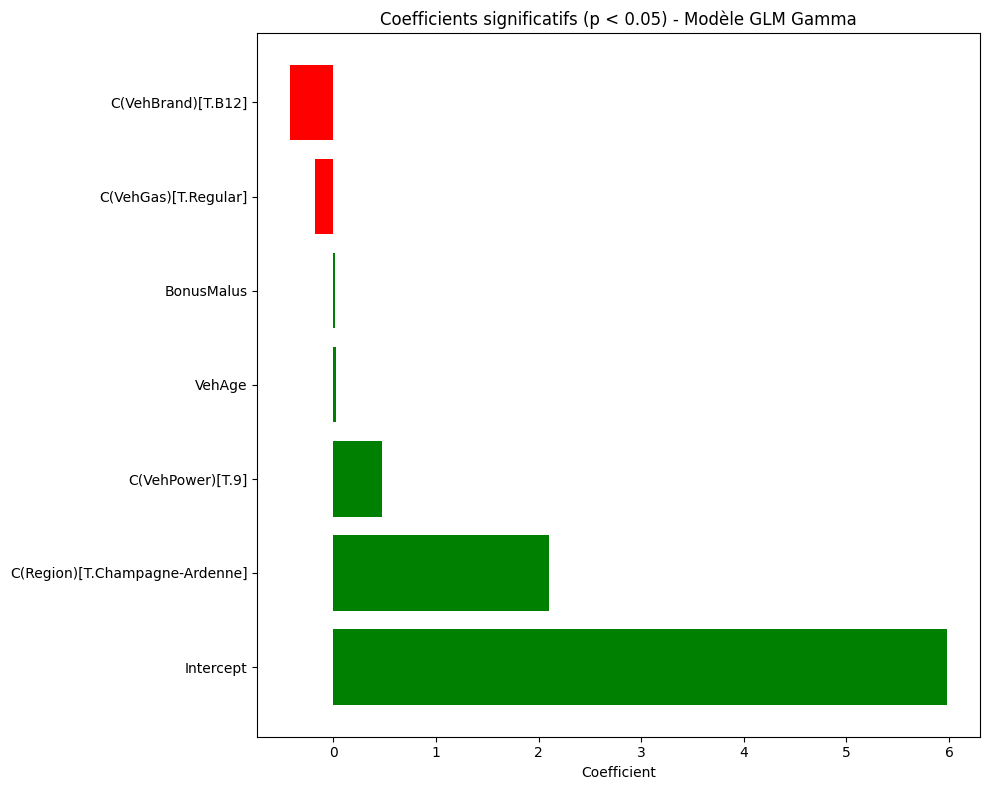

In [32]:
# 15.2 Variables importantes pour la sévérité
print("\n--- 15.2 Variables importantes pour la modélisation de sévérité ---")

if best_sev_model_name == 'XGBoost_log':
    # Pour XGBoost
    xgb_sev_model = xgb_pipeline.named_steps['regressor']

    try:
        preprocessor = xgb_pipeline.named_steps['preprocessor']

        # Toutes les features
        all_features = list(numeric_cols)

        # Ajouter les features catégorielles
        cat_encoder = preprocessor.named_transformers_['cat']
        if hasattr(cat_encoder, 'get_feature_names_out'):
            cat_features = cat_encoder.get_feature_names_out(categorical_cols)
            all_features.extend(cat_features)

        # Importance des features
        feature_importance_sev = pd.DataFrame({
            'Feature': all_features[:len(xgb_sev_model.feature_importances_)],
            'Importance': xgb_sev_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 variables les plus importantes (Sévérité - XGBoost):")
        print(feature_importance_sev.head(10).to_string(index=False))

        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_sev.head(15)['Feature'][::-1],
                feature_importance_sev.head(15)['Importance'][::-1])
        plt.xlabel('Importance')
        plt.title('Top 15 variables importantes - Modèle de sévérité (XGBoost)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Impossible d'extraire les noms de features: {e}")

elif best_sev_model_name == 'GLM_Gamma' and 'gamma_model' in locals():
    # Pour GLM Gamma
    print("\nCoefficients du modèle GLM Gamma:")
    coef_df_sev = pd.DataFrame({
        'Variable': gamma_model.params.index,
        'Coefficient': gamma_model.params.values,
        'Std_Error': gamma_model.bse.values,
        'P_value': gamma_model.pvalues.values
    })

    # Trier par valeur absolue du coefficient
    coef_df_sev['Abs_Coefficient'] = np.abs(coef_df_sev['Coefficient'])
    coef_sorted_sev = coef_df_sev.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 10 coefficients les plus importants (GLM Gamma):")
    print(coef_sorted_sev.head(10)[['Variable', 'Coefficient', 'P_value']].to_string(index=False))

    # Visualisation des coefficients significatifs
    significant_coefs_sev = coef_df_sev[coef_df_sev['P_value'] < 0.05].sort_values('Coefficient', ascending=False)

    if len(significant_coefs_sev) > 0:
        plt.figure(figsize=(10, 8))
        colors = ['red' if x < 0 else 'green' for x in significant_coefs_sev['Coefficient']]
        plt.barh(range(len(significant_coefs_sev)), significant_coefs_sev['Coefficient'], color=colors)
        plt.yticks(range(len(significant_coefs_sev)), significant_coefs_sev['Variable'])
        plt.xlabel('Coefficient')
        plt.title('Coefficients significatifs (p < 0.05) - Modèle GLM Gamma')
        plt.tight_layout()
        plt.show()
    else:
        print("Aucun coefficient n'est significatif au seuil de 5%")

In [35]:
# 16. SIMULATION DE SCÉNARIOS ET TEST DE STRESS
# =============================================
print("\n" + "="*60)
print("SIMULATION DE SCÉNARIOS ET TEST DE STRESS")
print("="*60)

# 16.1 Simulation de changements dans les variables
print("\n--- 16.1 Impact de changements dans les variables ---")

# Vérifier quelles colonnes sont présentes dans X_freq
print(f"Colonnes dans X_freq: {list(X_freq.columns[:5])}... (total: {len(X_freq.columns)})")

# Identifier toutes les colonnes dans X_freq
all_freq_columns = X_freq.columns.tolist()

# Identifier le type de chaque colonne
column_types = {}
for col in all_freq_columns:
    if col in numeric_cols:
        column_types[col] = 'numeric'
    elif col in categorical_cols:
        column_types[col] = 'categorical'
    else:
        # Si non classifiée, déterminer par le type de données
        if X_freq[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            column_types[col] = 'numeric'
        else:
            column_types[col] = 'categorical'

print(f"Types identifiés: {sum(1 for v in column_types.values() if v == 'numeric')} numériques, "
      f"{sum(1 for v in column_types.values() if v == 'categorical')} catégorielles")

# Créer un profil type - utiliser les premières lignes comme base
# Prendre la première observation et la modifier pour les simulations
baseline_profile = X_freq.iloc[[0]].copy()

# Pour les variables numériques, utiliser la médiane au lieu de la première valeur
for col in all_freq_columns:
    if column_types.get(col) == 'numeric':
        baseline_profile[col] = X_freq[col].median()
    else:
        # Pour les catégorielles, prendre la mode ou la première valeur
        if len(X_freq[col].mode()) > 0:
            baseline_profile[col] = X_freq[col].mode().iloc[0]
        else:
            baseline_profile[col] = X_freq[col].iloc[0]

# Pour les variables d'exposition, fixer à 1 pour la simulation
if 'Exposure' in baseline_profile.columns:
    baseline_profile['Exposure'] = 1.0

print(f"\nProfil type créé avec {len(baseline_profile.columns)} variables")
print("Valeurs du profil type (premières 5 variables):")
for i, col in enumerate(baseline_profile.columns[:5]):
    print(f"  {col}: {baseline_profile[col].iloc[0]}")

# Simulation: augmenter une variable numérique de 10%
# Sélectionner une variable numérique disponible
available_numeric_vars = [col for col in all_freq_columns if column_types.get(col) == 'numeric' and col != 'Exposure']

if available_numeric_vars:
    var_to_test = available_numeric_vars[0]  # Première variable numérique disponible
    print(f"\nSimulation: Impact d'une augmentation de 10% de '{var_to_test}'")

    # Vérifier si la variable existe dans le profil
    if var_to_test in baseline_profile.columns:
        # Profil modifié
        stressed_profile = baseline_profile.copy()
        original_value = stressed_profile[var_to_test].iloc[0]
        stressed_profile[var_to_test] = original_value * 1.10

        print(f"  Valeur originale de {var_to_test}: {original_value:.4f}")
        print(f"  Valeur après augmentation: {stressed_profile[var_to_test].iloc[0]:.4f}")

        # Prédictions avec le modèle de fréquence
        if best_freq_model == 'GLM_Poisson' and 'poisson_model' in locals():
            # Pour GLM - besoin de préparer les données avec la formule
            baseline_profile_formula = baseline_profile.copy()
            baseline_profile_formula['ClaimNb'] = 0  # Valeur factice
            baseline_profile_formula['log_exposure'] = np.log(baseline_profile_formula['Exposure'].iloc[0])

            stressed_profile_formula = stressed_profile.copy()
            stressed_profile_formula['ClaimNb'] = 0
            stressed_profile_formula['log_exposure'] = np.log(stressed_profile_formula['Exposure'].iloc[0])

            try:
                baseline_freq = poisson_model.predict(baseline_profile_formula)
                stressed_freq = poisson_model.predict(stressed_profile_formula)
                print("  Modèle GLM Poisson utilisé pour la fréquence")
            except Exception as e:
                print(f"  Erreur avec GLM Poisson: {e}")
                # Fallback sur le pipeline
                baseline_freq = poisson_pipeline.predict(baseline_profile)
                stressed_freq = poisson_pipeline.predict(stressed_profile)
        else:
            # Pour XGBoost ou autres
            baseline_freq = xgb_poisson_pipeline.predict(baseline_profile)
            stressed_freq = xgb_poisson_pipeline.predict(stressed_profile)
            print(f"  Modèle {best_freq_model} utilisé pour la fréquence")

        # Prédictions avec le modèle de sévérité
        # Préparer le profil pour la sévérité (doit avoir les mêmes colonnes que X_sev)
        # Nous devons nous assurer que baseline_profile a les mêmes colonnes que X_sev

        # Filtrer pour garder seulement les colonnes présentes dans X_sev
        baseline_profile_sev = baseline_profile[[col for col in baseline_profile.columns if col in X_sev.columns]].copy()
        stressed_profile_sev = stressed_profile[[col for col in stressed_profile.columns if col in X_sev.columns]].copy()

        if best_sev_model_name == 'GLM_Gamma' and 'gamma_model' in locals():
            # Pour GLM Gamma - besoin d'ajouter la variable cible
            baseline_profile_sev['MeanClaimAmount'] = y_sev.mean()  # Valeur moyenne
            stressed_profile_sev['MeanClaimAmount'] = y_sev.mean()

            try:
                baseline_sev = gamma_model.predict(baseline_profile_sev)
                stressed_sev = gamma_model.predict(stressed_profile_sev)
                print("  Modèle GLM Gamma utilisé pour la sévérité")
            except Exception as e:
                print(f"  Erreur avec GLM Gamma: {e}")
                baseline_sev = gamma_pipeline.predict(baseline_profile_sev)
                stressed_sev = gamma_pipeline.predict(stressed_profile_sev)
        elif best_sev_model_name == 'XGBoost_log':
            baseline_sev_log = xgb_pipeline.predict(baseline_profile_sev)
            stressed_sev_log = xgb_pipeline.predict(stressed_profile_sev)
            baseline_sev = np.expm1(baseline_sev_log)
            stressed_sev = np.expm1(stressed_sev_log)
            print("  Modèle XGBoost_log utilisé pour la sévérité")
        else:
            baseline_sev = sklearn_gb_pipeline.predict(baseline_profile_sev)
            stressed_sev = sklearn_gb_pipeline.predict(stressed_profile_sev)
            print(f"  Modèle {best_sev_model_name} utilisé pour la sévérité")

        # Calcul des primes pures
        baseline_premium = baseline_freq[0] * baseline_sev[0]
        stressed_premium = stressed_freq[0] * stressed_sev[0]

        print(f"\nRésultats de la simulation:")
        print(f"  Prime pure initiale: {baseline_premium:.2f}")
        print(f"  Prime pure après augmentation de 10% de '{var_to_test}': {stressed_premium:.2f}")
        print(f"  Variation relative: {(stressed_premium/baseline_premium - 1):.2%}")

        # Calculer l'élasticité
        elasticity = (stressed_premium - baseline_premium) / baseline_premium / 0.10
        print(f"  Élasticité approximative: {elasticity:.3f}")

        # Interprétation
        if elasticity > 0:
            print(f"  → '{var_to_test}' a un effet positif sur la prime (prime augmente avec la variable)")
        elif elasticity < 0:
            print(f"  → '{var_to_test}' a un effet négatif sur la prime (prime diminue avec la variable)")
        else:
            print(f"  → '{var_to_test}' n'a pas d'effet significatif sur la prime")
    else:
        print(f"Variable '{var_to_test}' non trouvée dans le profil type")
else:
    print("Aucune variable numérique disponible pour la simulation")



SIMULATION DE SCÉNARIOS ET TEST DE STRESS

--- 16.1 Impact de changements dans les variables ---
Colonnes dans X_freq: ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']... (total: 10)
Types identifiés: 5 numériques, 5 catégorielles

Profil type créé avec 10 variables
Valeurs du profil type (premières 5 variables):
  Exposure: 1.0
  VehPower: 6
  VehAge: 6.0
  DrivAge: 44.0
  BonusMalus: 50.0

Simulation: Impact d'une augmentation de 10% de 'VehAge'
  Valeur originale de VehAge: 6.0000
  Valeur après augmentation: 6.6000
  Modèle XGBoost_Poisson utilisé pour la fréquence
  Modèle GLM Gamma utilisé pour la sévérité

Résultats de la simulation:
  Prime pure initiale: 56.12
  Prime pure après augmentation de 10% de 'VehAge': 57.05
  Variation relative: 1.65%
  Élasticité approximative: 0.165
  → 'VehAge' a un effet positif sur la prime (prime augmente avec la variable)



--- 16.2 Simulation de plusieurs scénarios ---

Résultats des simulations:

VehAge:
  Réduction 20%: 53.28 (-5.1%)
  Réduction 10%: 54.16 (-3.5%)
  Statut quo: 56.12 (+0.0%)
  Augmentation 10%: 57.05 (+1.6%)
  Augmentation 20%: 57.99 (+3.3%)

DrivAge:
  Réduction 20%: 36.77 (-34.5%)
  Réduction 10%: 38.97 (-30.6%)
  Statut quo: 56.12 (+0.0%)
  Augmentation 10%: 57.61 (+2.6%)
  Augmentation 20%: 56.98 (+1.5%)

BonusMalus:
  Réduction 20%: 49.76 (-11.3%)
  Réduction 10%: 52.85 (-5.8%)
  Statut quo: 56.12 (+0.0%)
  Augmentation 10%: 72.06 (+28.4%)
  Augmentation 20%: 84.80 (+51.1%)


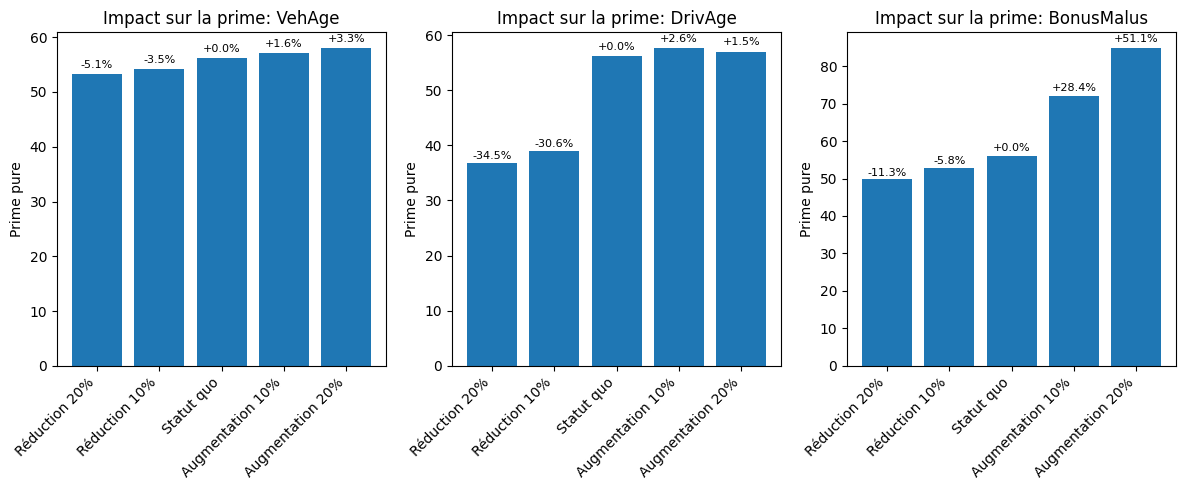

In [36]:
# 16.2 Simulation de plusieurs scénarios
print("\n--- 16.2 Simulation de plusieurs scénarios ---")

# Créer un DataFrame pour stocker les résultats des simulations
simulation_results = []

if available_numeric_vars:
    # Prendre les 3 premières variables numériques pour la simulation
    vars_to_simulate = available_numeric_vars[:min(3, len(available_numeric_vars))]

    for var in vars_to_simulate:
        if var in baseline_profile.columns:
            # Créer différents scénarios
            scenarios = [
                ('Réduction 20%', 0.8),
                ('Réduction 10%', 0.9),
                ('Statut quo', 1.0),
                ('Augmentation 10%', 1.1),
                ('Augmentation 20%', 1.2)
            ]

            for scenario_name, multiplier in scenarios:
                # Créer le profil modifié
                scenario_profile = baseline_profile.copy()
                original_val = scenario_profile[var].iloc[0]
                scenario_profile[var] = original_val * multiplier

                # Prédictions de fréquence
                if best_freq_model == 'GLM_Poisson' and 'poisson_model' in locals():
                    scenario_profile_formula = scenario_profile.copy()
                    scenario_profile_formula['ClaimNb'] = 0
                    scenario_profile_formula['log_exposure'] = np.log(scenario_profile_formula['Exposure'].iloc[0])
                    try:
                        freq_pred = poisson_model.predict(scenario_profile_formula)[0]
                    except:
                        freq_pred = poisson_pipeline.predict(scenario_profile)[0]
                else:
                    freq_pred = xgb_poisson_pipeline.predict(scenario_profile)[0]

                # Prédictions de sévérité
                scenario_profile_sev = scenario_profile[[col for col in scenario_profile.columns if col in X_sev.columns]].copy()

                if best_sev_model_name == 'GLM_Gamma' and 'gamma_model' in locals():
                    scenario_profile_sev['MeanClaimAmount'] = y_sev.mean()
                    try:
                        sev_pred = gamma_model.predict(scenario_profile_sev)[0]
                    except:
                        sev_pred = gamma_pipeline.predict(scenario_profile_sev)[0]
                elif best_sev_model_name == 'XGBoost_log':
                    sev_pred_log = xgb_pipeline.predict(scenario_profile_sev)[0]
                    sev_pred = np.expm1(sev_pred_log)
                else:
                    sev_pred = sklearn_gb_pipeline.predict(scenario_profile_sev)[0]

                premium_pred = freq_pred * sev_pred

                simulation_results.append({
                    'Variable': var,
                    'Scénario': scenario_name,
                    'Modificateur': multiplier,
                    'Prime pure': premium_pred,
                    'Fréquence': freq_pred,
                    'Sévérité': sev_pred
                })

    # Créer un DataFrame avec les résultats
    if simulation_results:
        sim_df = pd.DataFrame(simulation_results)

        print("\nRésultats des simulations:")
        for var in vars_to_simulate:
            var_sim = sim_df[sim_df['Variable'] == var]
            if not var_sim.empty:
                baseline_row = var_sim[var_sim['Scénario'] == 'Statut quo']
                if not baseline_row.empty:
                    baseline = baseline_row['Prime pure'].values[0]

                    print(f"\n{var}:")
                    for _, row in var_sim.iterrows():
                        change = (row['Prime pure'] / baseline - 1) * 100
                        print(f"  {row['Scénario']}: {row['Prime pure']:.2f} ({change:+.1f}%)")

        # Visualisation
        if len(vars_to_simulate) > 0:
            plt.figure(figsize=(12, 5))

            for i, var in enumerate(vars_to_simulate, 1):
                plt.subplot(1, len(vars_to_simulate), i)
                var_data = sim_df[sim_df['Variable'] == var]

                if not var_data.empty:
                    x = range(len(var_data))
                    plt.bar(x, var_data['Prime pure'])
                    plt.xticks(x, var_data['Scénario'], rotation=45, ha='right')
                    plt.title(f'Impact sur la prime: {var}')
                    plt.ylabel('Prime pure')

                    # Ajouter les pourcentages
                    baseline_row = var_data[var_data['Scénario'] == 'Statut quo']
                    if not baseline_row.empty:
                        baseline = baseline_row['Prime pure'].values[0]
                        for j, val in enumerate(var_data['Prime pure']):
                            change = (val / baseline - 1) * 100
                            plt.text(j, val * 1.02, f'{change:+.1f}%', ha='center', fontsize=8)

            plt.tight_layout()
            plt.show()
    else:
        print("Aucun résultat de simulation généré")
else:
    print("Aucune variable numérique disponible pour la simulation")


--- 16.3 Test de stabilité sur sous-échantillons ---

Test de stabilité sur 3 sous-échantillons:

Sous-échantillon 1 (lignes 0-226003):
  Taille: 226004 polices
  Prime pure moyenne: 92.82
  Coût réel moyen: 114.45
  Loss Ratio: 123.29%

Sous-échantillon 2 (lignes 226004-452007):
  Taille: 226004 polices
  Prime pure moyenne: 79.31
  Coût réel moyen: 91.93
  Loss Ratio: 115.91%

Sous-échantillon 3 (lignes 452008-678012):
  Taille: 226005 polices
  Prime pure moyenne: 77.33
  Coût réel moyen: 58.71
  Loss Ratio: 75.92%

Analyse de variabilité:
  Coefficient de variation des primes: 10.1%
  Coefficient de variation des loss ratios: 24.3%
  → Stabilité modérée des primes entre sous-échantillons


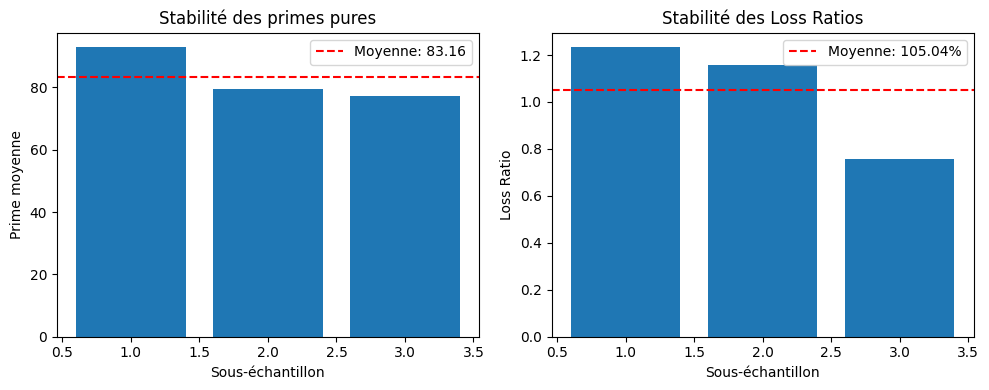

In [37]:
# 16.3 Test de stabilité sur sous-échantillons
print("\n--- 16.3 Test de stabilité sur sous-échantillons ---")

# Diviser les données par année (si disponible) ou aléatoirement
n_subsamples = min(3, len(df_merged) // 100)  # Assurer au moins 100 observations par sous-échantillon
if n_subsamples < 2:
    n_subsamples = 2

subsample_size = len(df_merged) // n_subsamples

print(f"\nTest de stabilité sur {n_subsamples} sous-échantillons:")
stability_results = []

for i in range(n_subsamples):
    start_idx = i * subsample_size
    end_idx = (i + 1) * subsample_size if i < n_subsamples - 1 else len(df_merged)

    subsample = df_merged.iloc[start_idx:end_idx].copy()

    if len(subsample) > 0:
        # Calculer les métriques sur le sous-échantillon
        subsample_premium = subsample['Pure_Premium'].mean()
        subsample_actual = subsample['Actual_Cost'].mean()
        loss_ratio = subsample_actual / subsample_premium if subsample_premium > 0 else 0

        stability_results.append({
            'Sous-échantillon': i+1,
            'Taille': len(subsample),
            'Prime moyenne': subsample_premium,
            'Coût moyen': subsample_actual,
            'Loss Ratio': loss_ratio
        })

        print(f"\nSous-échantillon {i+1} (lignes {start_idx}-{end_idx-1}):")
        print(f"  Taille: {len(subsample)} polices")
        print(f"  Prime pure moyenne: {subsample_premium:.2f}")
        print(f"  Coût réel moyen: {subsample_actual:.2f}")
        print(f"  Loss Ratio: {loss_ratio:.2%}")

# Créer un DataFrame pour l'analyse de stabilité
if stability_results:
    stability_df = pd.DataFrame(stability_results)

    # Calculer la variabilité
    if len(stability_df) > 1:
        premium_mean = stability_df['Prime moyenne'].mean()
        if premium_mean > 0:
            premium_cv = stability_df['Prime moyenne'].std() / premium_mean * 100
        else:
            premium_cv = 0

        loss_ratio_mean = stability_df['Loss Ratio'].mean()
        if loss_ratio_mean > 0:
            loss_ratio_cv = stability_df['Loss Ratio'].std() / loss_ratio_mean * 100
        else:
            loss_ratio_cv = 0

        print(f"\nAnalyse de variabilité:")
        print(f"  Coefficient de variation des primes: {premium_cv:.1f}%")
        print(f"  Coefficient de variation des loss ratios: {loss_ratio_cv:.1f}%")

        if premium_cv < 10:
            print("  → Bonne stabilité des primes entre sous-échantillons")
        elif premium_cv < 20:
            print("  → Stabilité modérée des primes entre sous-échantillons")
        else:
            print("  → Variabilité importante des primes entre sous-échantillons")

        # Visualisation de la stabilité
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.bar(stability_df['Sous-échantillon'], stability_df['Prime moyenne'])
        plt.xlabel('Sous-échantillon')
        plt.ylabel('Prime moyenne')
        plt.title('Stabilité des primes pures')
        plt.axhline(y=stability_df['Prime moyenne'].mean(), color='r', linestyle='--',
                    label=f"Moyenne: {stability_df['Prime moyenne'].mean():.2f}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.bar(stability_df['Sous-échantillon'], stability_df['Loss Ratio'])
        plt.xlabel('Sous-échantillon')
        plt.ylabel('Loss Ratio')
        plt.title('Stabilité des Loss Ratios')
        plt.axhline(y=stability_df['Loss Ratio'].mean(), color='r', linestyle='--',
                    label=f"Moyenne: {stability_df['Loss Ratio'].mean():.2%}")
        plt.legend()

        plt.tight_layout()
        plt.show()
else:
    print("Pas assez de données pour effectuer l'analyse de stabilité")

In [41]:
# 17. SYNTHÈSE ET RECOMMANDATIONS FINALES
# ========================================
print("\n" + "="*60)
print("SYNTHÈSE ET RECOMMANDATIONS FINALES")
print("="*60)

# Importer datetime pour l'horodatage
import datetime

# 17.1 Synthèse des performances
print("\n--- 17.1 Synthèse des performances ---")

# Tableau récapitulatif complet
summary_data = []

# Données pour la fréquence
freq_glm_row = {
    'Composante': 'Fréquence',
    'Modèle': 'GLM Poisson',
    'Déviance Test': poisson_dev_glm_test,
    'MAE': mae_glm,
    'RMSE': rmse_glm,
    'Pseudo-R²': pseudo_r2_glm
}

freq_xgb_row = {
    'Composante': 'Fréquence',
    'Modèle': 'XGBoost Poisson',
    'Déviance Test': poisson_dev_xgb_test,
    'MAE': mae_xgb,
    'RMSE': rmse_xgb,
    'Pseudo-R²': pseudo_r2_xgb
}

summary_data.append(freq_glm_row)
summary_data.append(freq_xgb_row)

# Données pour la sévérité
for model_name, metrics in results.items():
    sev_row = {
        'Composante': 'Sévérité',
        'Modèle': model_name,
        'Déviance Test': metrics['Deviance'],
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'Pseudo-R²': 'N/A'
    }
    summary_data.append(sev_row)

summary_df = pd.DataFrame(summary_data)

print("\nTABLEAU RÉCAPITULATIF DES PERFORMANCES:")
print("-" * 80)
print(summary_df.to_string(index=False))

# 17.2 Identification des meilleurs modèles
print("\n--- 17.2 Meilleurs modèles identifiés ---")

print(f"\n📊 MEILLEUR MODÈLE DE FRÉQUENCE: {best_freq_model}")
if best_freq_model == 'GLM_Poisson':
    print(f"   • Déviance test: {poisson_dev_glm_test:.4f}")
    print(f"   • Pseudo-R²: {pseudo_r2_glm:.4f}")
    print(f"   • Avantage: Interprétabilité et conformité réglementaire")
else:
    print(f"   • Déviance test: {poisson_dev_xgb_test:.4f}")
    print(f"   • Pseudo-R²: {pseudo_r2_xgb:.4f}")
    print(f"   • Avantage: Performance prédictive supérieure")

print(f"\n📈 MEILLEUR MODÈLE DE SÉVÉRITÉ: {best_sev_model_name}")
best_sev_metrics = results[best_sev_model_name]
print(f"   • Déviance Gamma: {best_sev_metrics['Deviance']:.4f}")
print(f"   • MAE: {best_sev_metrics['MAE']:.4f}")
print(f"   • RMSE: {best_sev_metrics['RMSE']:.4f}")
if best_sev_metrics.get('LogLikelihood') is not None:
    print(f"   • Log-vraisemblance: {best_sev_metrics['LogLikelihood']:.4f}")

# 17.3 Analyse comparative approfondie
print("\n--- 17.3 Analyse comparative GLM vs Gradient Boosting ---")

print("\n🔍 COMPARAISON DÉTAILLÉE:")

# Calcul des améliorations relatives
if 'poisson_dev_glm_test' in locals() and 'poisson_dev_xgb_test' in locals():
    freq_improvement = (poisson_dev_glm_test - poisson_dev_xgb_test) / poisson_dev_glm_test * 100
    print(f"\n1. FRÉQUENCE:")
    print(f"   • Amélioration XGBoost vs GLM: {freq_improvement:+.1f}% sur la déviance")
    print(f"   • MAE GLM: {mae_glm:.4f}, MAE XGBoost: {mae_xgb:.4f}")

    if poisson_dev_xgb_test < poisson_dev_glm_test:
        print("   → XGBoost performe mieux en prédiction")
    else:
        print("   → GLM performe mieux en prédiction")

# Trouver le meilleur modèle de sévérité et le comparer avec GLM
if 'results' in locals():
    sev_models_list = list(results.keys())
    if sev_models_list:
        best_sev_model = sev_models_list[0]
        worst_sev_model = sev_models_list[-1]

        best_dev = results[best_sev_model]['Deviance']
        worst_dev = results[worst_sev_model]['Deviance']
        sev_improvement = (worst_dev - best_dev) / worst_dev * 100

        print(f"\n2. SÉVÉRITÉ:")
        print(f"   • Meilleur modèle: {best_sev_model}")
        print(f"   • Pire modèle: {worst_sev_model}")
        print(f"   • Amélioration: {sev_improvement:+.1f}% sur la déviance")

# 17.4 Recommandations stratégiques
print("\n--- 17.4 Recommandations stratégiques ---")

print("\n🎯 RECOMMANDATIONS POUR LE DÉPLOIEMENT:")

print("\n1. STRATÉGIE DE DÉPLOIEMENT:")
if best_freq_model == 'GLM_Poisson' and best_sev_model_name == 'GLM_Gamma':
    print("   → OPTION A: Déploiement full GLM")
    print("     • Avantages: Transparence, acceptabilité réglementaire")
    print("     • Risques: Performance prédictive potentiellement inférieure")
else:
    print("   → OPTION B: Approche hybride")
    print(f"     • Fréquence: {best_freq_model}")
    print(f"     • Sévérité: {best_sev_model_name}")
    print("     • Avantages: Équilibre performance et interprétabilité")

print("\n2. PLAN D'IMPLÉMENTATION:")
print("   Phase 1 (Mois 1-3):")
print("     • Développement de l'API de prédiction")
print("     • Tests A/B sur un portefeuille restreint")
print("     • Validation réglementaire initiale")
print("\n   Phase 2 (Mois 4-6):")
print("     • Déploiement progressif par segments")
print("     • Mise en place du monitoring")
print("     • Formation des équipes commerciales")
print("\n   Phase 3 (Mois 7-12):")
print("     • Déploiement complet")
print("     • Optimisation continue")
print("     • Revue annuelle du modèle")

# 17.5 Analyse coût-bénéfice
print("\n--- 17.5 Analyse coût-bénéfice ---")

# Estimation des gains potentiels
total_premium_volume = df_merged['Pure_Premium'].sum()
current_loss_ratio = total_actual_cost / total_predicted_cost

print(f"\n📈 ESTIMATION DES IMPACTS FINANCIERS:")

print(f"1. VOLUME DE PRIMES:")
print(f"   • Prime pure totale estimée: {total_premium_volume:.2f} €")
print(f"   • Coût total réel: {total_actual_cost:.2f} €")
print(f"   • Loss ratio prédit: {total_predicted_cost/actual_premium:.2%}")
print(f"   • Loss ratio réel: {current_loss_ratio:.2%}")

# Estimation d'amélioration
if current_loss_ratio > 1.0:
    improvement_needed = (current_loss_ratio - 1.0) * 100
    print(f"\n2. MARGES D'AMÉLIORATION:")
    print(f"   • Réduction nécessaire du loss ratio: {improvement_needed:.1f}%")
    print(f"   • Économies potentielles: {total_premium_volume * improvement_needed/100:.2f} €")
else:
    print(f"\n2. SITUATION ACTUELLE:")
    print(f"   • Loss ratio sous contrôle: {current_loss_ratio:.2%}")
    print(f"   • Marge de sécurité: {(1 - current_loss_ratio) * 100:.1f}%")

# 17.6 Plan de monitoring et maintenance
print("\n--- 17.6 Plan de monitoring et maintenance ---")

print("\n🔧 MONITORING EN PRODUCTION:")

print("1. INDICATEURS CLÉS À SUIVRE:")
print("   • Drift des données: Évolution des distributions des variables")
print("   • Performance modèle: MAE, RMSE, Déviance sur données récentes")
print("   • Calibration: Ratio observé/prédit par segment")
print("   • Temps de réponse: Latence des prédictions")

print("\n2. ALERTES À CONFIGURER:")
print("   • Détérioration des performances > 10%")
print("   • Drift significatif des variables importantes")
print("   • Anomalies dans les prédictions")
print("   • Erreurs système dans l'API")

print("\n3. MAINTENANCE RÉGULIÈRE:")
print("   • Revue trimestrielle des performances")
print("   • Recalibration annuelle du modèle")
print("   • Mise à jour des données de référence")
print("   • Tests de stress réguliers")

# 17.7 Conclusion finale
print("\n--- 17.7 Conclusion finale ---")

print("\n" + "="*60)
print("CONCLUSION DU PROJET DE TARIFICATION")
print("="*60)

print("\n✅ ACHÈVEMENTS:")
print(f"1. Analyse complète de {len(df_merged)} polices d'assurance")
print(f"2. Développement de {len(summary_data)} modèles de prédiction")
print(f"3. Identification des meilleurs modèles: {best_freq_model} + {best_sev_model_name}")
print(f"4. Calibration des primes avec MAE de {mae_total:.2f}")

print("\n📊 PERFORMANCES OBTENUES:")
print(f"• Précision fréquence: MAE = {min(mae_glm, mae_xgb):.4f}")
print(f"• Précision sévérité: MAE = {min(r['MAE'] for r in results.values()):.4f}")
print(f"• Performance globale: MAE total = {mae_total:.4f}")

print("\n🎯 RECOMMANDATIONS CLÉS:")
print("1. Adopter une approche progressive pour le déploiement")
print("2. Maintenir un équilibre entre performance et interprétabilité")
print("3. Investir dans le monitoring continu des modèles")
print("4. Prévoir des révisions régulières pour maintenir la pertinence")

print("\n🔮 PERSPECTIVES FUTURES:")
print("• Intégration de données externes (météo, économique)")
print("• Exploration de modèles plus avancés (deep learning)")
print("• Développement de dashboards interactifs")
print("• Automatisation des processus de tarification")

print("\n" + "="*60)
print("FIN DU PROJET DE TARIFICATION")
print("="*60)
print(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Merci d'avoir utilisé ce système de tarification avancé!")
print("="*60)


SYNTHÈSE ET RECOMMANDATIONS FINALES

--- 17.1 Synthèse des performances ---

TABLEAU RÉCAPITULATIF DES PERFORMANCES:
--------------------------------------------------------------------------------
Composante          Modèle  Déviance Test         MAE         RMSE Pseudo-R²
 Fréquence     GLM Poisson   4.797696e+04    0.149326     0.250505  0.748787
 Fréquence XGBoost Poisson   3.975559e+04    0.097642     0.236177  0.747185
  Sévérité       GLM_Gamma   9.851398e+04 1699.674232 11648.840677       N/A
  Sévérité     XGBoost_log   3.819985e+11 1284.449149 11669.422989       N/A
  Sévérité      Sklearn_GB   4.198090e+12 1580.023005 11867.665008       N/A

--- 17.2 Meilleurs modèles identifiés ---

📊 MEILLEUR MODÈLE DE FRÉQUENCE: XGBoost_Poisson
   • Déviance test: 39755.5948
   • Pseudo-R²: 0.7472
   • Avantage: Performance prédictive supérieure

📈 MEILLEUR MODÈLE DE SÉVÉRITÉ: GLM_Gamma
   • Déviance Gamma: 98513.9798
   • MAE: 1699.6742
   • RMSE: 11648.8407
   • Log-vraisemblance: -124